# **Advanced Machine Learning Project - Toxic Comments**


> - **Authors:**
  - Gargiulo Elio - 869184
  - Gervasi Alessandro - 866140
  - Piacente Cristian - 866020
- **Course:** Advanced Machine Learning
- **A.Y:** 2024/25
- **University:** Milano Bicocca - Master Degree in Computer Science



> This project follows the general aim of the kaggle competition "Toxic comments". The challenge is to build a model that's capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate. The dataset of comments is given by Wikipedia's talk page edits.

## **Libraries and Configurations**
> This section imports the necessary libraries for the notebook and sets up some configurations.

In [ ]:
# The project is done on Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython.display import display

# Pandas and NumPy
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np

# For Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Wordcloud
from wordcloud import WordCloud, STOPWORDS

# General
from collections import Counter

# For Text Processing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# For Sentiment Scores
from nltk.sentiment import SentimentIntensityAnalyzer

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Tensorflow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, GRU, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## **Importing the Data**

> This section focuses on importing the data correctly and showing initial information about the data.

> The dataset is split into Train and Test (with labels on an another file)

In [ ]:
# Import the dataset
train_df=pd.read_csv("/content/drive/MyDrive/Progetto AML - Toxic Comments/Dataset/train.csv")
test_df=pd.read_csv("/content/drive/MyDrive/Progetto AML - Toxic Comments/Dataset/test.csv")
test_labels_df=pd.read_csv("/content/drive/MyDrive/Progetto AML - Toxic Comments/Dataset/test_labels.csv")

### **Importing the Data: Train set**

In [ ]:
# Showing the head
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [ ]:
# Showing how many records there are
train_df.shape

(159571, 8)

### **Importing the Data: Test set**

In [ ]:
# Showing the head
test_df.head()

,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
# Showing how many records there are
test_df.shape

(153164, 2)

In [ ]:
# Checking the labels
test_labels_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
# Showing how many record there are (labels)
test_labels_df.shape

(153164, 7)

> There are several labels equal to -1. This could mean that for some examples the label could be considered missing (-1).

> The distribution of each column shows that there are indeed also 0 and 1 labels for each category, so the value -1 is not useful for the next parts.

In [ ]:
# Calculate value counts for each column (distribution)
value_counts = test_labels_df.drop(columns='id').apply(lambda x: x.value_counts())

# Display the value counts
print(value_counts)

    toxic  severe_toxic  obscene  threat  insult  identity_hate
-1  89186         89186    89186   89186   89186          89186
 0  57888         63611    60287   63767   60551          63266
 1   6090           367     3691     211    3427            712


> It is also possible to see that the value -1 is consistent for each columns (classes), so if there is a -1 in the row, every class assumes that value.

In [ ]:
# Check if at least one label is -1
at_least_one_negative = (test_labels_df.drop(columns='id') == -1).any(axis=1)

# Check if not all labels are -1
not_all_negative = (test_labels_df.drop(columns='id') != -1).any(axis=1)

# Combine the conditions
mask = at_least_one_negative & not_all_negative

test_labels_df[mask]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate


> The filtered dataframe shows exactly what has been said above, so the next step is to remove every row that contains the value -1.

In [ ]:
test_labels_df = test_labels_df[~(test_labels_df.drop(columns='id') == -1).all(axis=1)]

> Finally, the test set can be merged with its labels.

In [ ]:
# Merge the dataframes
test_merged_df = pd.merge(test_df, test_labels_df, on='id')

# Reset the index
test_merged_df = test_merged_df.reset_index(drop=True)

In [ ]:
# Showing the head
test_merged_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a type. The """"Type"""" of institution is needed in this case because there are three levels of SUNY schools: \n -University Centers and Doctoral Granting Institutions \n -State Colleges \n -Community Colleges. \n\n It is needed in this case to clarify that UB is a SUNY Center. It says it even in Binghamton University, University at Albany, State University of New York, and Stony Brook University. Stop trying to say it's not because I am totally right in this case.""",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the list, make sure it's relevant == \n\n Before adding a new product to the list, make sure it has a wikipedia entry already, """"proving"""" it's relevance and giving the reader the possibility to read more about it. \n Otherwise it could be subject to deletion. See this article's revision history.""",0,0,0,0,0,0


In [ ]:
# Showing how many record there are
test_merged_df.shape

(63978, 8)

### **Importing the Data: Train-Test distribution**

> Before starting with the Exploratory Data Analysis, it is possible to visualize the distribution of the two sets and check if they are already split correctly.

> Usually the correct percentages include:
  - 70% Training set
  - 30% Test set

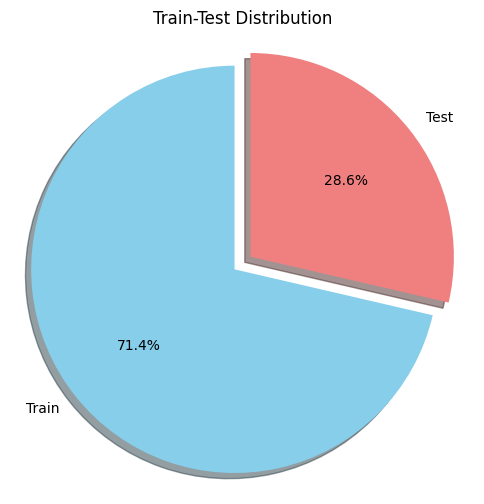

In [ ]:
# Data for the pie chart
labels = ['Train', 'Test']
sizes = [len(train_df), len(test_merged_df)]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  # explode the train slice

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Train-Test Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

> The pie-chart shows that the train and test set are already split correctly.

## **Exploratory Data Analysis (EDA)**

> This section focuses on analyzing the dataset to ensure it is clean and consistent, while also examining the general distribution of the data and relationships between variables.

> Specifically, the analysis includes:
  - **Data Cleaning:** Checking for missing values and duplicate rows.  
  - **Comment Distribution:** Analyzing the proportion of toxic vs non-toxic comments.  
  - **Univariate Analysis:** Visualizing individual labels (e.g., word clouds and class distribution).  
  - **Covariate Analysis:** Investigating relationships between labels (e.g., correlation matrix, class distribution against clean comments, and crosstabs).


### **Data Cleaning Checks**

> In this section, we ensure that the dataset is clean and ready for analysis by checking for missing values and duplicate rows. Identifying and addressing these issues is crucial to maintain data consistency and integrity throughout the analysis.


#### **Duplicate Rows**


In [ ]:
# Check for duplicate rows in the training dataset
duplicate_rows_train = train_df[train_df.duplicated()]

# Print the number of duplicate rows
print(f"Number of duplicate rows in the training dataset: {len(duplicate_rows_train)}")

# Display the duplicate rows if any
if not duplicate_rows_train.empty:
    print("\nDuplicate rows in the training dataset:")
duplicate_rows_train

Number of duplicate rows in the training dataset: 0


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


#### **Missing Values**


In [ ]:
# Check for missing values in each column of the training dataset
missing_values_train = train_df.isnull().sum()
missing_values_train.rename('Missing values sum in train')

,Missing values sum in train
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


### **Non-toxic (clean) comments distribution**

> The distribution of non-toxic and toxic comments provides insight into the class balance of the dataset. This information is essential for understanding the potential challenges the models may face when learning to classify comments, regardless of the specific type of toxicity.

In [ ]:
# Count rows where all labels are 0
zero_labels_count = len(train_df[(train_df['toxic'] == 0) & (train_df['severe_toxic'] == 0) & (train_df['obscene'] == 0) & (train_df['threat'] == 0) & (train_df['insult'] == 0) & (train_df['identity_hate'] == 0)])

# Calculate the percentage
zero_labels_percentage = (zero_labels_count / len(train_df)) * 100

print(f"Number of total rows in the training set: {len(train_df)}")
print(f"Number of rows with all labels equal to 0: {zero_labels_count}\n")

print(f"Percentage of rows with all labels equal to 0: {zero_labels_percentage:.2f}%")

Number of total rows in the training set: 159571
Number of rows with all labels equal to 0: 143346

Percentage of rows with all labels equal to 0: 89.83%


> The clean comments are much more present that the toxic ones.

### **Univariate Analysis**

> This section explores individual labels of the dataset to understand their distributions and patterns. Visualizations such as word clouds and class distribution charts help identify key characteristics of the data.

#### **Class Distribution (Toxic Comments)**

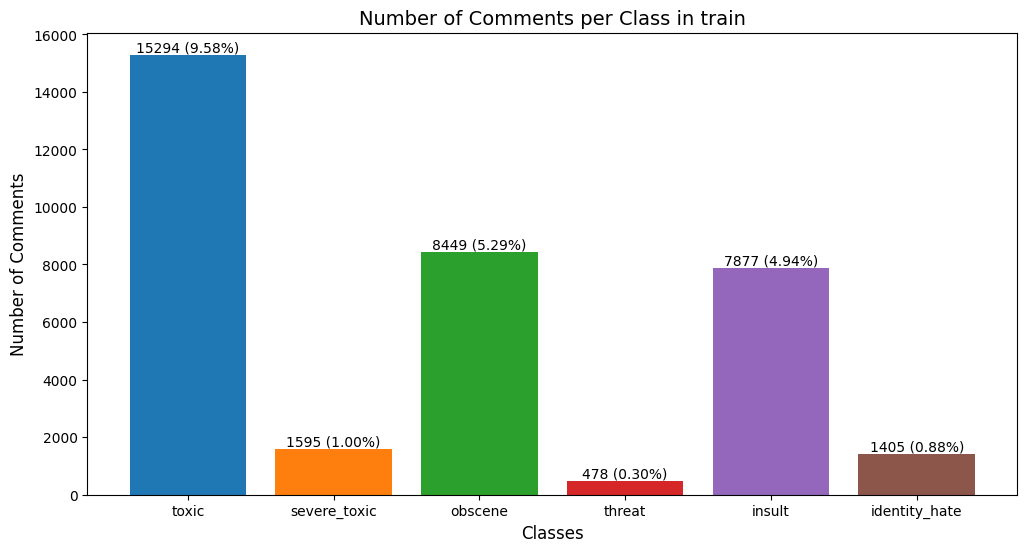

In [ ]:
# Create a new dataframe with the counts of each class
class_counts = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()

# Create a list of colors for the bars
colors = sns.color_palette("tab10", len(class_counts))

plt.figure(figsize=(12, 6))
bars = plt.bar(class_counts.index, class_counts.values, color=colors)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.title("Number of Comments per Class in train", fontsize=14)

# Add text annotations with exact numbers and percentages
total_comments = len(train_df)
for bar, count in zip(bars, class_counts.values):
  height = bar.get_height()
  percentage = (count / total_comments) * 100
  plt.text(bar.get_x() + bar.get_width() / 2, height,
            f'{int(count)} ({percentage:.2f}%)', ha='center', va='bottom', fontsize=10)

plt.show()

> Most of the comments are classified as Toxic, while Threats are very rare.

#### **Word Clouds**

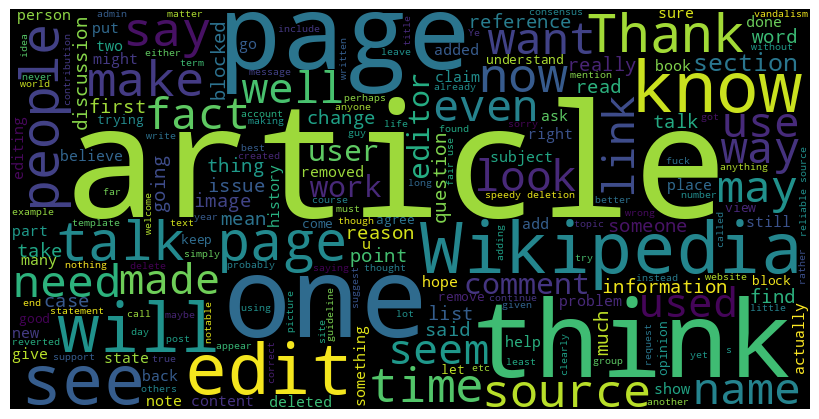

In [ ]:
text = " ".join(train_df['comment_text'].astype(str))

# Create stopword list
stopwords = set(STOPWORDS)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='black',
                      stopwords=stopwords,
                      min_font_size=10).generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

> The word cloud shows the most frequent words used in the comments.

### **Covariate Analysis**

> This section examines relationships between multiple labels to identify potential correlations and patterns. Analysis includes correlation matrices, class distribution comparisons against clean comments, and crosstabs.


#### **Correlation Matrix**

> The correlation matrix provides a visual representation of the relationships between different toxic comment labels in the dataset.

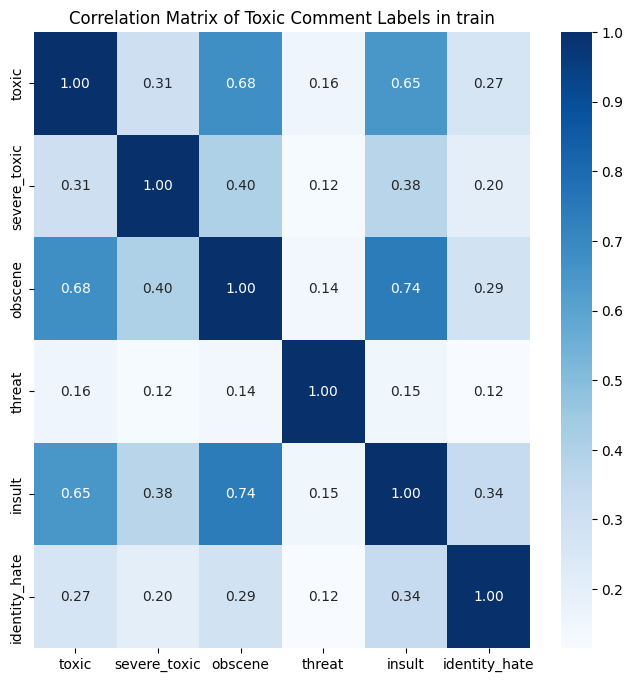

In [ ]:
corr = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix of Toxic Comment Labels in train")
plt.show()

> For example, insult and obscene have an high correlation (the value is higher than 0.7), meaning that usually a comment that contains an insult is also classified as obscene.

#### **Distribution of Toxic Comments Labels**

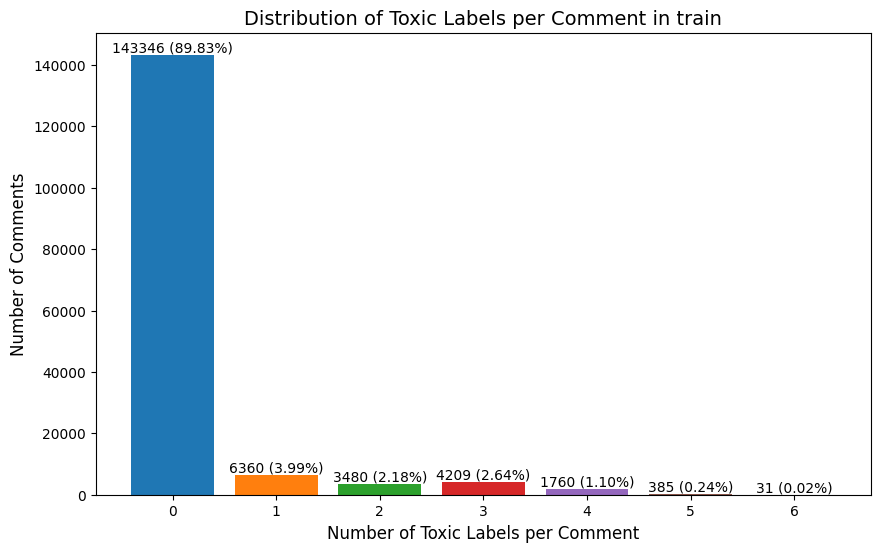

In [ ]:
# Calculate the sum of labels for each row
train_df_copy = train_df.copy()
train_df_copy['sum_labels'] = train_df_copy[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)

# Count the occurrences of each label sum
label_counts = train_df_copy['sum_labels'].value_counts().sort_index()

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=sns.color_palette("tab10", len(label_counts)))
plt.xlabel("Number of Toxic Labels per Comment", fontsize=12)
plt.ylabel("Number of Comments", fontsize=12)
plt.title("Distribution of Toxic Labels per Comment in train", fontsize=14)

# Add text annotations with exact numbers and percentages
total_comments = len(train_df_copy)
for bar, count in zip(bars, label_counts.values):
    height = bar.get_height()
    percentage = (count / total_comments) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(count)} ({percentage:.2f}%)', ha='center', va='bottom', fontsize=10)

plt.show()

> As seen before, most of the comments are indeed "clean".

#### **Crosstabs**

> Crosstab analysis is used to examine the relationships between the "toxic" label and the other toxic categories, which are "severe_toxic," "obscene," "threat," "insult," and "identity_hate".

In [ ]:
# Crosstab 'toxic' vs all other
print("Crosstab toxic vs other labels in train\n\n")
for col in ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
  print(f"Toxic vs {col}")
  normalized_table = crosstab = pd.crosstab(train_df['toxic'], train_df[col])
  display(normalized_table)
  print("-"*30)

Crosstab toxic vs other labels in train


Toxic vs severe_toxic


severe_toxic,0,1
toxic,,
0,144277,0
1,13699,1595


------------------------------
Toxic vs obscene


obscene,0,1
toxic,,
0,143754,523
1,7368,7926


------------------------------
Toxic vs threat


threat,0,1
toxic,,
0,144248,29
1,14845,449


------------------------------
Toxic vs insult


insult,0,1
toxic,,
0,143744,533
1,7950,7344


------------------------------
Toxic vs identity_hate


identity_hate,0,1
toxic,,
0,144174,103
1,13992,1302


------------------------------


In [ ]:
# Same crosstab but normalized by columns
print("Normalized crosstab by columns in train\n\n")
for col in ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
  print(f"Toxic vs {col}")
  normalized_table = crosstab = pd.crosstab(train_df['toxic'], train_df[col], normalize='columns')
  display(normalized_table)
  print("-"*30)

Normalized crosstab by columns in train


Toxic vs severe_toxic


severe_toxic,0,1
toxic,,
0,0.913284,0.0
1,0.086716,1.0


------------------------------
Toxic vs obscene


obscene,0,1
toxic,,
0,0.951245,0.061901
1,0.048755,0.938099


------------------------------
Toxic vs threat


threat,0,1
toxic,,
0,0.90669,0.060669
1,0.09331,0.939331


------------------------------
Toxic vs insult


insult,0,1
toxic,,
0,0.947592,0.067665
1,0.052408,0.932335


------------------------------
Toxic vs identity_hate


identity_hate,0,1
toxic,,
0,0.911536,0.07331
1,0.088464,0.92669


------------------------------


## **Text Processing**

> This section focuses on preparing textual data for analysis and model training. Key steps include tokenization, removing stop words and lemmatization. These techniques ensure consistency and improve model performance.

In [ ]:
# Copy the train df
train_df_copy = train_df.copy()

### **Useful functions**

> The **preprocess_text** function performs all the preprocessing steps mentioned in the section description. Specifically, it includes:
  - **Tokenization:** Using `TweetTokenizer` to split text into tokens.  
  - **Normalization and Noise Removal:** Removing links, username tags, newline tags, and emoticons.  
  - **Stopword Removal:** Eliminating common words (e.g., "the," "is") that provide little semantic value.  
  - **Lemmatization:** Reducing words to their base forms, ensuring they're valid vocabulary words, for better text consistency.


> **TweetTokenizer** is the tokenizer used because there are some emoticons and unique characteristics that are frequently used in comments. The following parameters are used:
  - **preserve_case=False** automatically converts to lowercase
  - **reduce_len** reduces the length of words containing too many repeated letters
  - **strip_handles** removes the citations (e.g., @User)

In [ ]:
# Config tokenizer and lemmatizer
tokenizer=TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
# Preprocess a text. It returns lemmatized tokens.
def preprocess_text(text):
  # Tokenization
  tokens = tokenizer.tokenize(text)
  # Remove non-alphanumeric ("normalization") and stop words in 1 step
  # --> This removes IPs, Links, Username tags, emoticons & stop words (e.g., "the")
  tokens = [word for word in tokens if (word.isalnum()) and (word not in stopwords)]
  # Lemmatization
  lemmatized_tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
  return lemmatized_tokens

In [ ]:
# Compare a specific comment before processing and after processing, given the ID.
def compare_comment(id):
  # Display original
  print("Original comment:")
  display(train_df[train_df['id'] == f'{id}']['comment_text'])

  # Display processed
  print("\nProcessed comment:")
  display(train_df_copy[train_df_copy['id'] == f'{id}']['comment_text'])

In [ ]:
# Plot for each class the top 10 TF-IDF n-grams, with n parameter.
def plot_tfidf_analysis(n, title_substr):
  # Initialize TF-IDF vectorizer, do not use min_df because we already cut the stop words before
  tfv = TfidfVectorizer(
    strip_accents='unicode', stop_words='english',
    ngram_range=(n, n)
  )

  # n-grams
  ngrams = tfv.fit_transform(train_df_copy['comment_text'])
  ngrams_names = np.array(tfv.get_feature_names_out())

  # Extract top TF-IDF n-grams per class, sorted by score
  labels = train_df_copy[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
  dfs_by_class = []
  for label in labels.columns:
      ids = labels.index[labels[label] == 1].tolist()
      if ids:
          tfidf_means = np.mean(ngrams[ids].toarray(), axis=0)
          topn_ids = np.argsort(-tfidf_means)[:10]
          df = pd.DataFrame({'ngram': ngrams_names[topn_ids], 'tfidf': tfidf_means[topn_ids]})
          df['label'] = label
          dfs_by_class.append(df.sort_values(by='tfidf', ascending=False))

  # Plot top n-grams per class
  plt.figure(figsize=(16, 22))
  plt.suptitle(f"TF-IDF Top Words per Class ({title_substr})", fontsize=20)
  colors = sns.color_palette("husl", len(dfs_by_class))

  for idx, class_feats in enumerate(dfs_by_class):
      plt.subplot(4, 2, idx + 1)
      sns.barplot(x=class_feats.ngram, y=class_feats.tfidf, color=colors[idx])
      plt.title(f"Class: {class_feats['label'].iloc[0]}", fontsize=15)
      plt.xlabel('Term', fontsize=12)
      plt.ylabel('TF-IDF Score', fontsize=12)
      plt.xticks(rotation=30, ha='right')

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [ ]:
# Add annotations to a bar plot.
def add_annotations(ax):
  for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

### **Text Processing and Effects**

In [ ]:
# Apply text processing and keep the list of lemmatized tokens
train_df_copy['comment_tokens'] = train_df_copy['comment_text'].apply(preprocess_text)

In [ ]:
# Keep also the string version
train_df_copy['comment_text'] = train_df_copy['comment_tokens'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
# Add the count of tokens, for each processed comment
train_df_copy['comment_tokens_count'] = train_df_copy['comment_tokens'].apply(len)

> Showing some examples of the processed train set.

In [ ]:
train_df_copy.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_tokens,comment_tokens_count
13724,243bd2d71d3cc0df,stated reason deleting pov statement now threatening ban typical wonder threatened ban bletch keep sneaking bias article,0,0,0,0,0,0,"[stated, reason, deleting, pov, statement, now, threatening, ban, typical, wonder, threatened, ban, bletch, keep, sneaking, bias, article]",17
72419,c1ced4ead8ff4758,really control georgie calling ugly picture lie arrogant arbitrary never threatened harassed deservedly wikzilla mean moron go ahead range block several million people really smart go ahead range block really think stopped first time piss thousand potential contributor,1,0,0,0,0,0,"[really, control, georgie, calling, ugly, picture, lie, arrogant, arbitrary, never, threatened, harassed, deservedly, wikzilla, mean, moron, go, ahead, range, block, several, million, people, really, smart, go, ahead, range, block, really, think, stopped, first, time, piss, thousand, potential, contributor]",38
155416,bd87a16da09863d7,applies usa recipe vary regionally,0,0,0,0,0,0,"[applies, usa, recipe, vary, regionally]",5
115063,673dc5bac4337b93,bjp pro hindutva vanamonde 93 living world past 10 year many people pulled lot propaganda tried every way let people frighten saying bjp hindutva based monster etc etc people india give hoot fanatic propaganda selected bjp rss guy now prime minister didnt message yet let tell clearly people india dont give damn racist propaganda savvy,1,0,0,0,0,0,"[bjp, pro, hindutva, vanamonde, 93, living, world, past, 10, year, many, people, pulled, lot, propaganda, tried, every, way, let, people, frighten, saying, bjp, hindutva, based, monster, etc, etc, people, india, give, hoot, fanatic, propaganda, selected, bjp, rss, guy, now, prime, minister, didnt, message, yet, let, tell, clearly, people, india, dont, give, damn, racist, propaganda, savvy]",55
75875,cb020874be9149d2,delete soon,0,0,0,0,0,0,"[delete, soon]",2
72364,c1b6fd5ff7b76ca8,hello jackson 214 advise intimidated passive aggressive incorrect accusation vandalism far see wikipedia rule removing incorrect poorly substantiated information blp page perfectly acceptable accusing vandalism acceptable,0,0,0,0,0,0,"[hello, jackson, 214, advise, intimidated, passive, aggressive, incorrect, accusation, vandalism, far, see, wikipedia, rule, removing, incorrect, poorly, substantiated, information, blp, page, perfectly, acceptable, accusing, vandalism, acceptable]",26
49197,83800cac949274e2,well search genetic speriority schockley hardly going wide range result bias research process unless shockley stated white superior black inferior removed anything mere speculation individual less educated subject shockley,0,0,0,0,0,0,"[well, search, genetic, speriority, schockley, hardly, going, wide, range, result, bias, research, process, unless, shockley, stated, white, superior, black, inferior, removed, anything, mere, speculation, individual, less, educated, subject, shockley]",29
137383,df10092147712b0c,ga review review transcluded talk laurence canterbury ga1 edit link section used add comment review bit clear suprises guess given almost complete ignorance medieval english history think gregorian mission mentioned lead need word two explanation convert christianity similar consecrated archbishop lifetime predecessor augustine canterbury continued effort coordinate native bishop britain although effort unsuccessful dearly love combine two sentence way understand saying two archbishop canterbury time consecrated laurence continued effort coordinate native bishop way unsuccessful fatuorum,0,0,0,0,0,0,"[ga, review, review, transcluded, talk, laurence, canterbury, ga1, edit, link, section, used, add, comment, review, bit, clear, suprises, guess, given, almost, complete, ignorance, medieval, english, history, think, gregorian, mission, mentioned, lead, need, word, two, explanation, convert, christianity, similar, consecrated, archbishop, lifetime, predecessor

#### **Some particular cases**

> The following cases show the effects of text processing, where for instance \n (newlines), IP Addresses and Links are removed. This helps with reducing noisy and irrelevant data.

In [ ]:
# Emoticon and new line
compare_comment('4783d0e06eb9fd81')

Original comment:


,comment_text
27006,"""\n\nChile\n\nCielo Estrellado please please do not support Al Andalus on this. The word Mestizo is never used in the hispanic world to describe people who are predominantly European as is the case for most Chileans. \n\nFirstly, as you may know, in Latin America it is used for those who are predominantly amerindian in their ancestry. (It would apply in Mexico and Central America). \nSecondly, there is no defined ethnic group in Chile which can be defined as mestizo, there are just people with more or less Indian bood, Spanish origin being nearly always the larger part of the ancestry. There is no sense of common belonging shared exclusively by people with amerindian ancestry which excludes people who dont have this ancestry. This is a vital characteristic of an ethnic group.\nThe word mestizo is pejorative in our language and should be used as little as possible. Ill give you an example. When the movie """"Harry Potter and the half-blood prince"""" came out in the Spanish speaking world, it was translated into Harry Potter and the Prince, because of the negative connotations that the word mestizo implied.\nFinally, in our cultural community, Latinness, Spanishness (or if you want to use racial terms """"whiteness"""") is an expansive concept which does not exclude people placind then in a different ethnic group on the basis of their blood being """"tainted"""" as happens in the Anglo Saxon world. Although, I agree that that in certain countries where racial divisions have been stronger due to a much larger Amerindian community, (such as Peru or Guatemala) leading to implications regarding identity and ethnicity..\n\nAnyways I hope you understand my position and we can establish some dialogue on this issue which transcends the narrow (and in my opinion racist) perspective of Genetic studies.\nI also hope you are not a sock puppet of user: al andalus! This would make things much harder:-)\n """



Processed comment:


,comment_text
27006,chile cielo estrellado please please support al andalus word mestizo never used hispanic world describe people predominantly european case chilean firstly may know latin america used predominantly amerindian ancestry apply mexico central america secondly defined ethnic group chile defined mestizo people less indian bood spanish origin nearly always larger part ancestry sense common belonging shared exclusively people amerindian ancestry excludes people dont ancestry vital characteristic ethnic group word mestizo pejorative language used little possible ill give example movie harry potter prince came spanish speaking world translated harry potter prince negative connotation word mestizo implied finally cultural community latinness spanishness want use racial term whiteness expansive concept exclude people placind different ethnic group basis blood tainted happens anglo saxon world although agree certain country racial division stronger due much larger amerindian community peru guatemala leading implication regarding identity ethnicity anyways hope understand position establish dialogue issue transcends narrow opinion racist perspective genetic study hope sock puppet user al andalus make thing much harder


In [ ]:
# Russian is correctly kept
compare_comment('49cc3c62cd1fa8f9')

Original comment:


,comment_text
27881,"otrs 2010032110008071 \n\nHi. I've looked through that otrs-ticket. Summary:\n it covers all text materials of these sites:\n http://leningradartist.com/\n http://www.leningradschool.com/\n it covers all text materials of these books:\n Иванов С. В. Неизвестный соцреализм. Ленинградская школа. -СПб: НП-Принт, 2007. - 450 с. ISBN 9785901724217, ISBN 5901724216 \n english: Sergei V. Ivanov. Unknown Socialist Realism. The Leningrad School\n it covers all images of these sites and books\n there is a special template - commons:User:Leningradartist/Permission\nIf there are any questions, ask them on my ru:User_talk:Rubin16 page in ru.wiki"



Processed comment:


,comment_text
27881,otrs 2010032110 008071 hi looked summary cover text material site cover text material book иванов с в неизвестный соцреализм ленинградская школа спб 2007 450 с isbn 9785901724 217 isbn 5901724216 english sergei v ivanov unknown socialist realism leningrad school cover image site book special template common user leningradartist permission question ask ru rubin 16 page


In [ ]:
# IP Address
compare_comment('49cf34955bb54135')

Original comment:


,comment_text
27886,Plot\n\nWhat the heck is the movie about? What are the main story lines? The plot description in the article tells me nothing! The trailer for the movie makes little sense. I get the idea of past lives. But what are the stories in the movie? Marc S. Dania Fl. 206.192.35.125



Processed comment:


,comment_text
27886,plot heck movie main story line plot description article tell nothing trailer movie make little sense idea past life story movie marc s dania fl


In [ ]:
# Link address
compare_comment('de0b8d88636024bd')

Original comment:


,comment_text
157434,One Night in Japan\nYou can edit in this page http://en.wikipedia.org/wiki/One_Night_In_Japan



Processed comment:


,comment_text
157434,one night japan edit page


#### **Processed Tokens Analysis**

> The following plot shows the distribution of the tokens after processing the comments text.

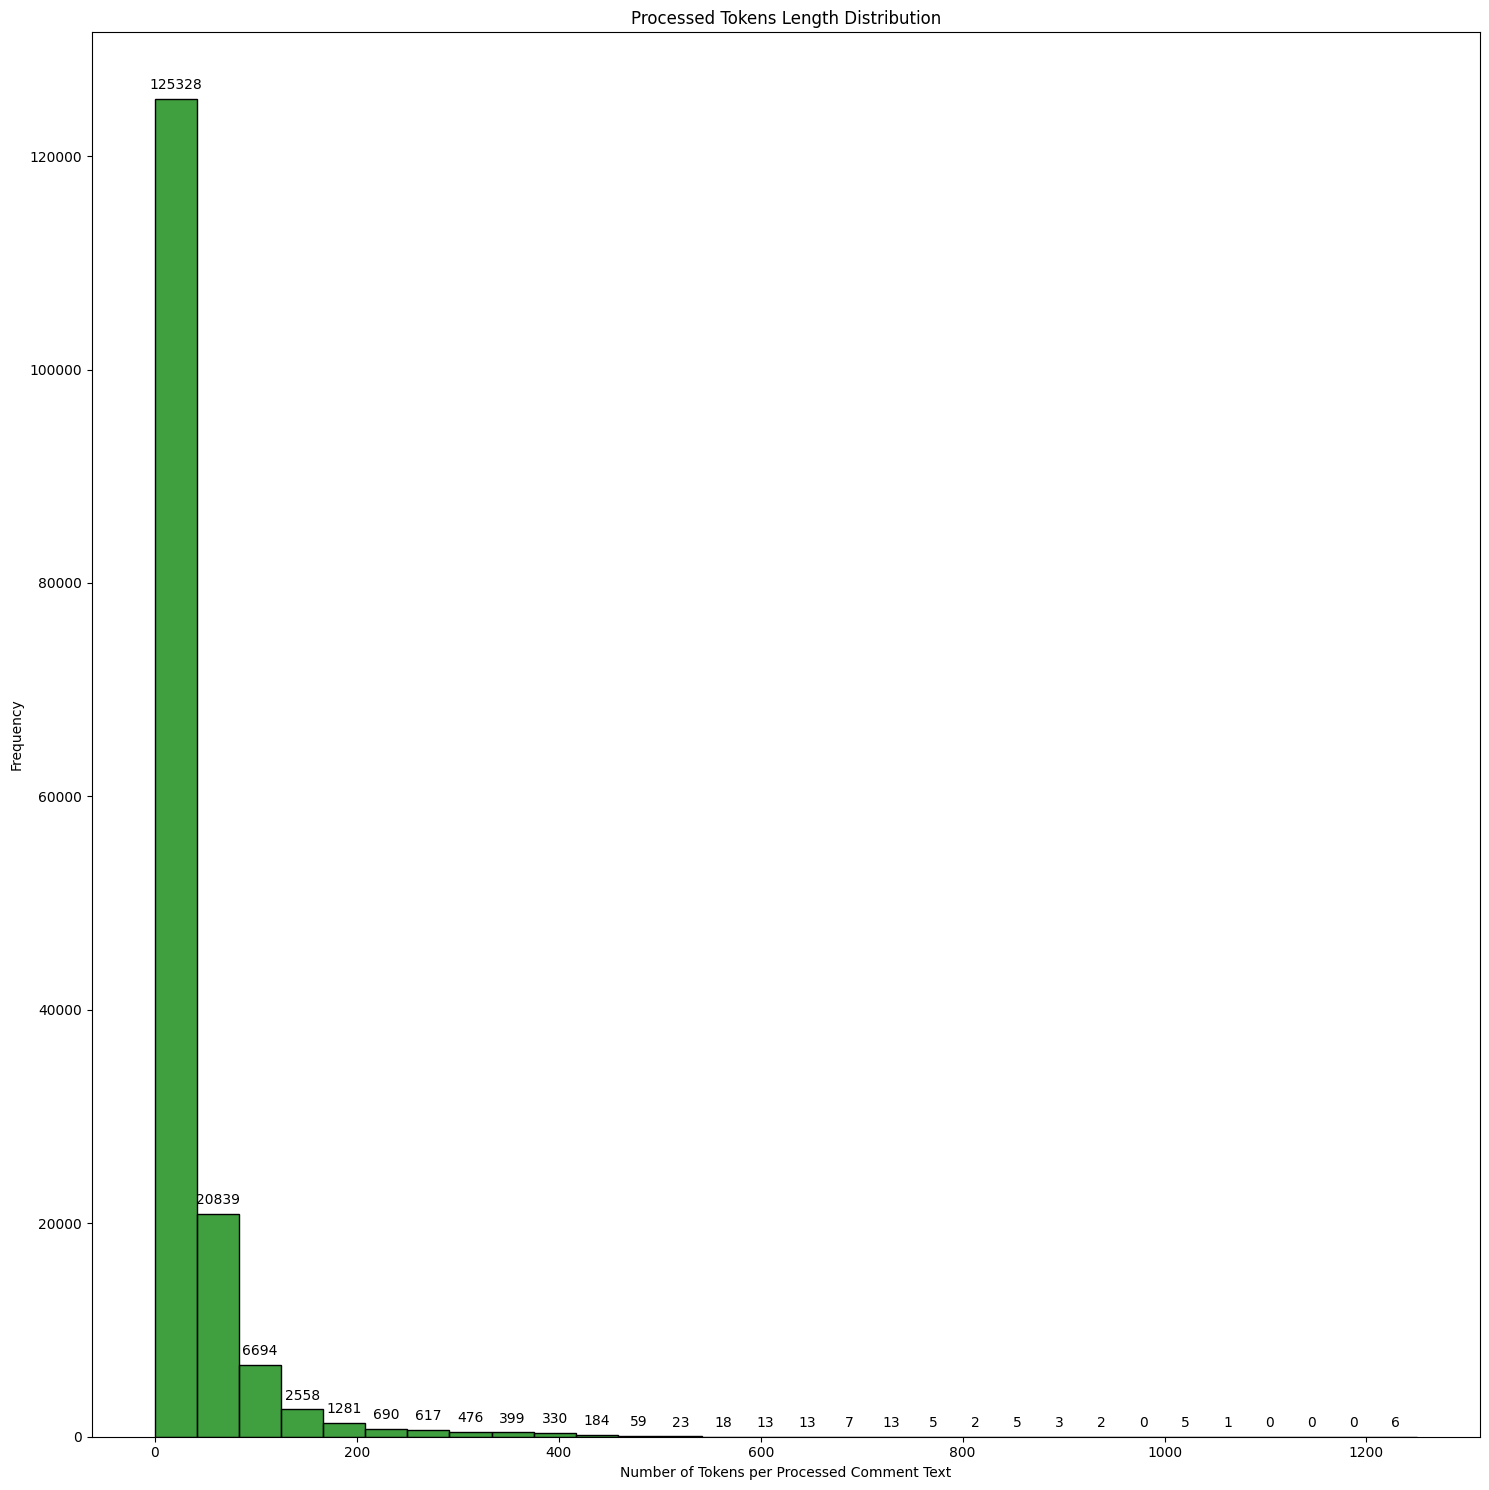

In [ ]:
# Set up the figure
plt.figure(figsize=(15, 15))

# Plot Processed Tokens Count
ax1 = sns.histplot(train_df_copy['comment_tokens_count'], color='green', bins=30)
plt.xlabel("Number of Tokens per Processed Comment Text")
plt.ylabel("Frequency")
plt.title("Processed Tokens Length Distribution")
add_annotations(ax1)

# Adjust layout
plt.tight_layout()
plt.show()

> There are tons (~120k) of short comments, which are a very high percentage with respect to the training set (less than 160k).

#### **Analysis With TF-IDF Weights**

> The effects of Text Processing are shown using TF-IDF weights, to plot the top 10 n-grams for each label.

##### **Unigrams Analysis**

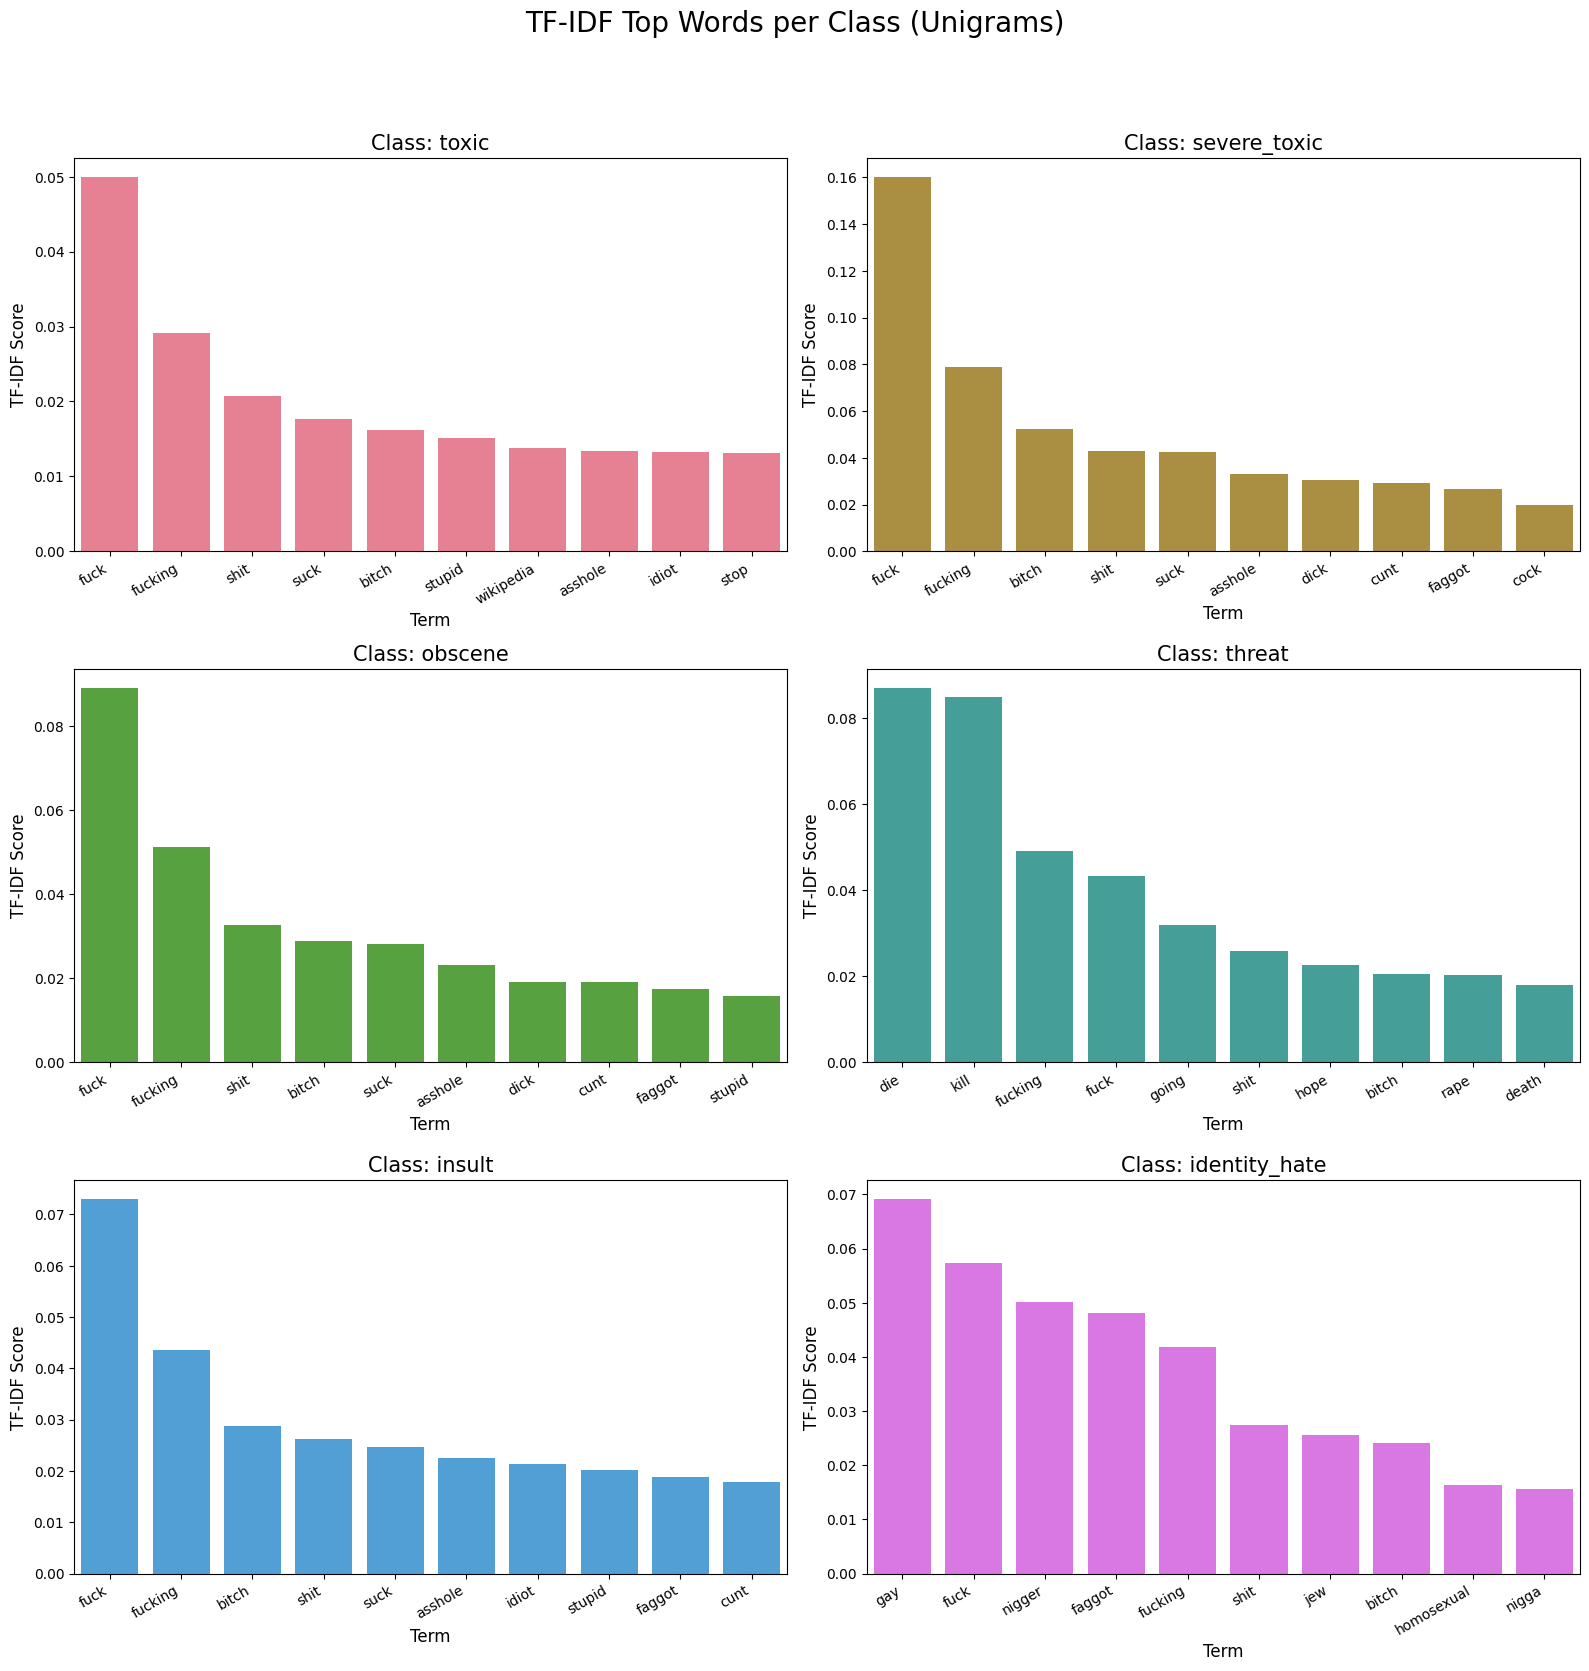

In [ ]:
# Analyze top 10 unigrams per label, using TF-IDF weights

plot_tfidf_analysis(1, "Unigrams")

> Unigrams show the kind of terms we expected to see for each class.

##### **Bigrams Analysis**

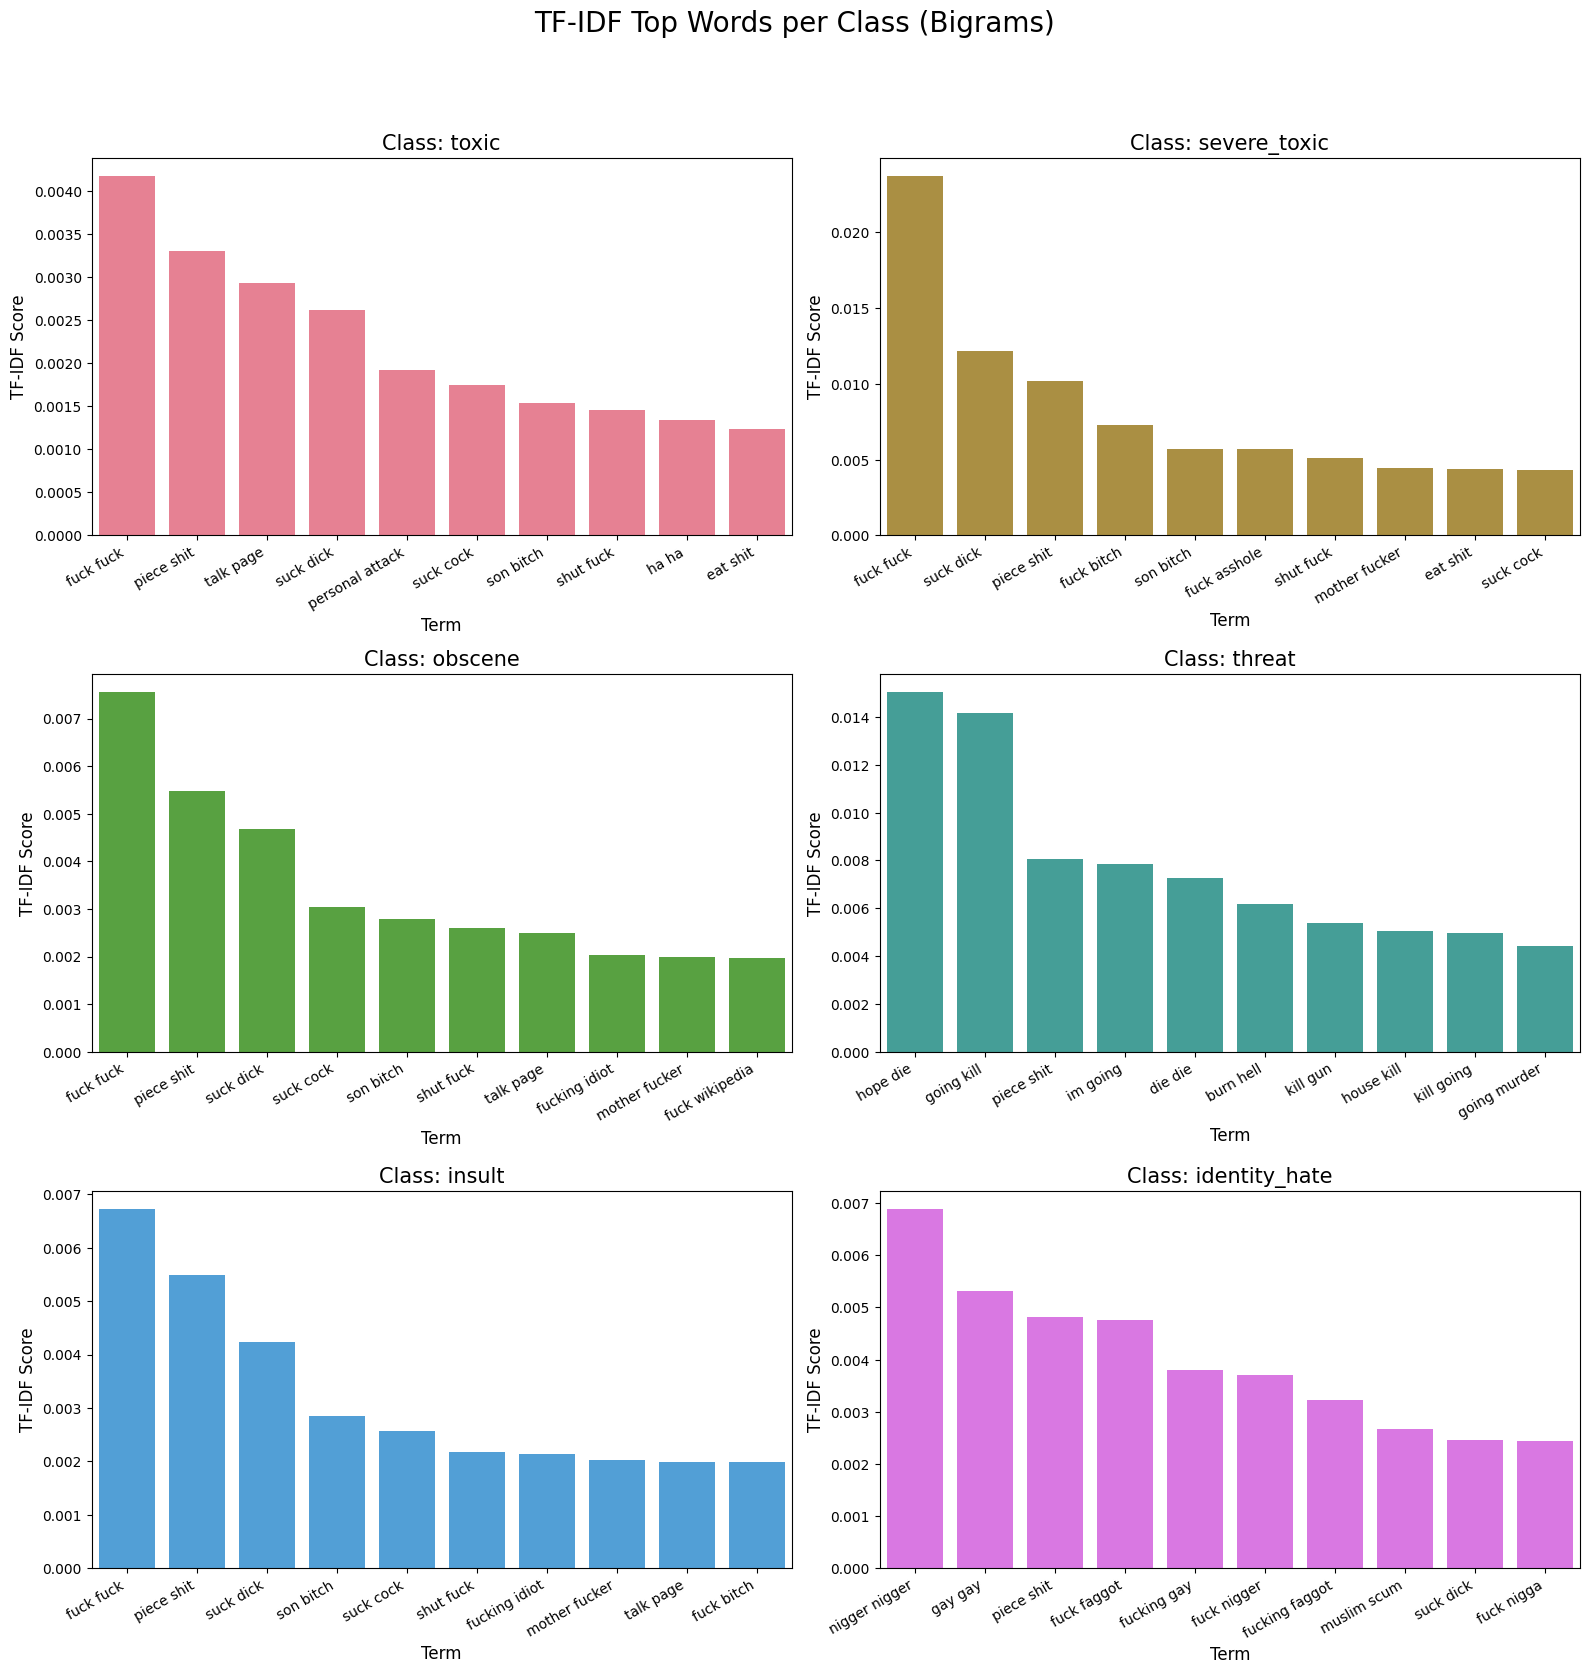

In [ ]:
# Analyze top 10 bigrams per label, using TF-IDF weights

plot_tfidf_analysis(2, "Bigrams")

> Bigrams also show relevant terms with respect to the class.

## **Sentiment Scores Analysis**

- **Negative**: It depicts the negative sentiment and its value ranges from 0 to 1.

- **Neutral**: It depicts the neutral sentiment and its value ranges from 0 to 1.

- **Positive**: It depicts the positive sentiment and its value ranges from 0 to 1.

- **Compound**: It provides us the overall sentiment score and its value ranges from -1 to 1, -1 being the strong negative sentiment and 1 being the strong positive sentiment.

##### **Building the Sentiment Dataframe**

In [ ]:
sid = SentimentIntensityAnalyzer()

# Return dictionary: {'neg': ..., 'neu': ..., 'pos': ..., 'compound': ...}
def get_sentiment_scores(text):
    return sid.polarity_scores(text)

# Apply to your DataFrame
sentiment_dicts = train_df_copy['comment_text'].apply(get_sentiment_scores)

# Convert the list of dicts into a DataFrame
sentiment_df = pd.DataFrame(sentiment_dicts.tolist())

##### **Sentiment Scores Plots**

> Let's analyze the distribution of the sentiment scores.

In [ ]:
# Function for plotting sentiment distributions
def plot_sentiment_distributions(sentiment_df):
    plt.figure(figsize=(20, 20))

    # Plot neg
    plt.subplot(4, 1, 1)
    sns.histplot(sentiment_df['neg'], color='red', kde=True, bins=30)
    plt.xlabel("Negative Sentiment Score")
    plt.ylabel("Frequency")
    plt.title("Negative Sentiment Scores Distribution")

    # Plot neu
    plt.subplot(4, 1, 2)
    sns.histplot(sentiment_df['neu'], color='orange', kde=True, bins=30)
    plt.xlabel("Neutral Sentiment Score")
    plt.ylabel("Frequency")
    plt.title("Neutral Sentiment Scores Distribution")

    # Plot pos
    plt.subplot(4, 1, 3)
    sns.histplot(sentiment_df['pos'], color='green', kde=True, bins=30)
    plt.xlabel("Positive Sentiment Score")
    plt.ylabel("Frequency")
    plt.title("Positive Sentiment Scores Distribution")

    # Plot compound
    plt.subplot(4, 1, 4)
    sns.histplot(sentiment_df['compound'], color='lightblue', kde=True, bins=30)
    plt.xlabel("Compound Sentiment Score")
    plt.ylabel("Frequency")
    plt.title("Compound Sentiment Scores Distribution")

    # Adjust layout
    plt.tight_layout()
    plt.show()

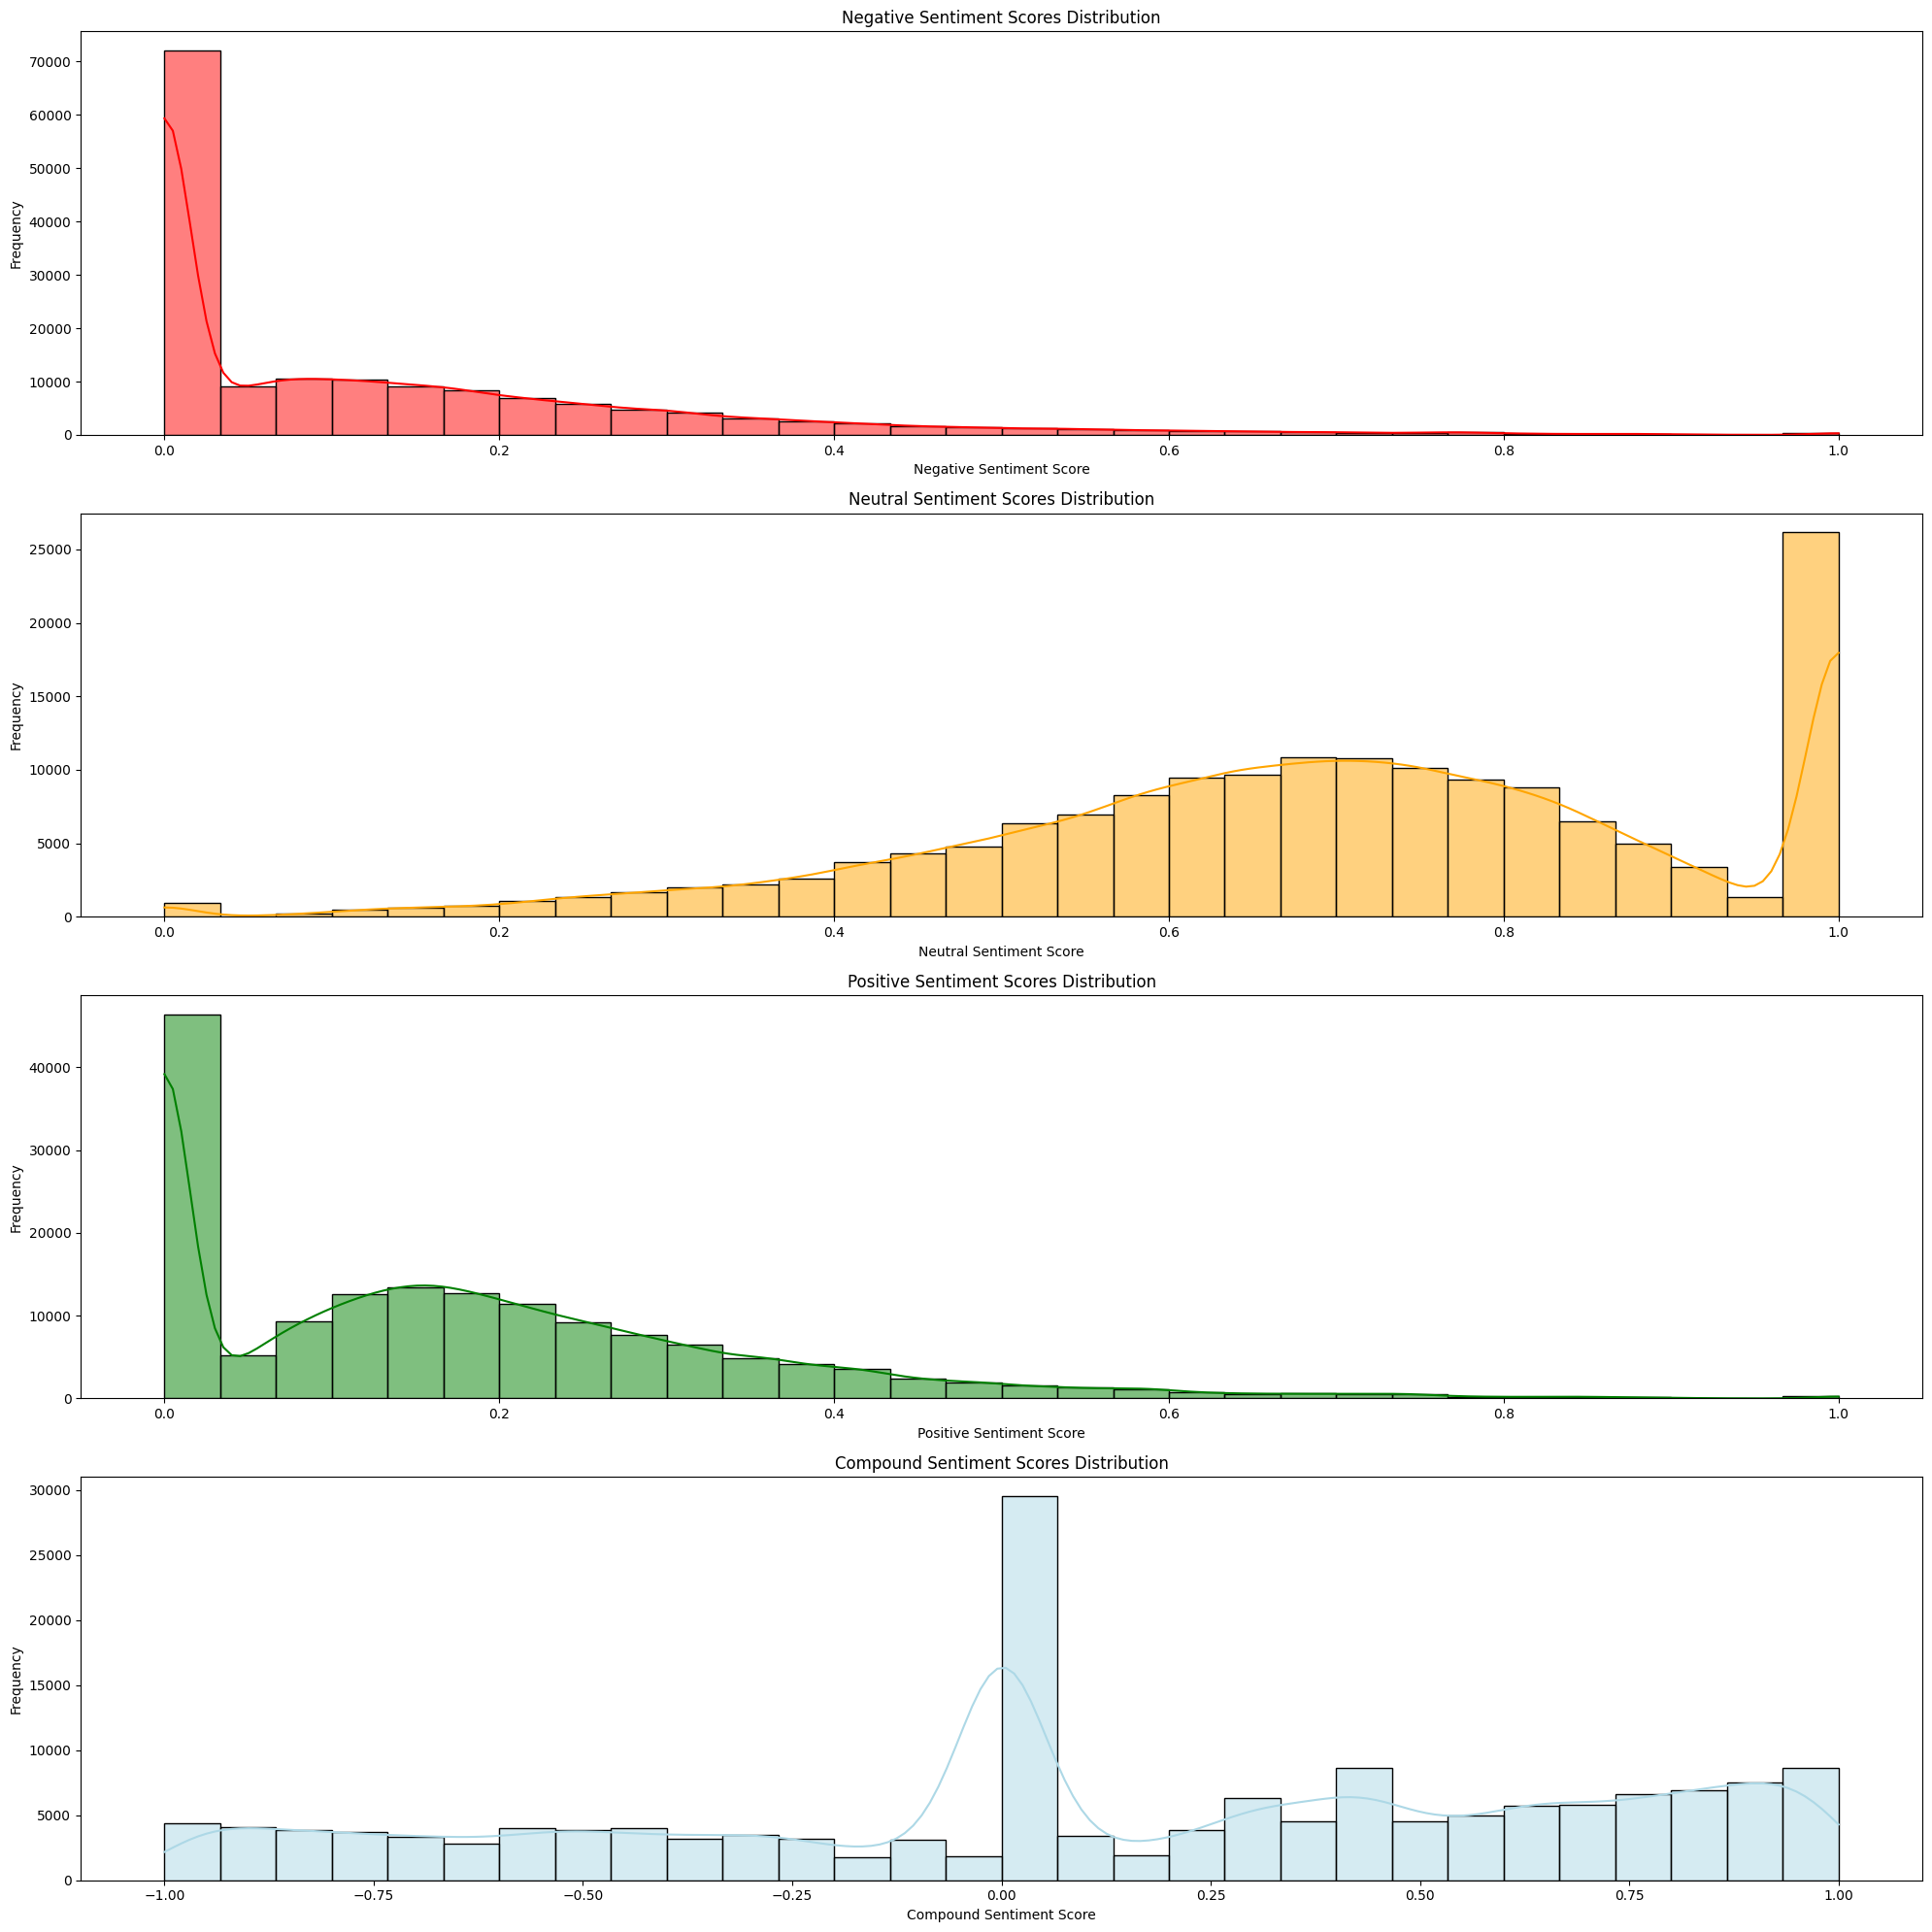

In [ ]:
plot_sentiment_distributions(sentiment_df)

> The plots show that most of the comments have a **neutral** sentiment, while **positive** and **negative (probably toxic)** are much less. This confirms that most of the comments are indeed clean.

## **Feature Engineering**

> In this section sequences will be created, which are later fed to the ML models for training.

> In particular, a vocabulary of a limited number of tokens is created, where each distinct token has a unique ID, then the length of each sequence is limited while using padding where needed.

> Each sequence will have the token IDs and eventually 0s for padding.

> Out Of Vocabulary tokens are also handled using an additional ID at the end of the vocabulary.

### **Training set before FE**

> Before starting FE, this is the current processed train DataFrame:

In [ ]:
train_df_copy.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_tokens,comment_tokens_count
0,0000997932d777bf,explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page retired now,0,0,0,0,0,0,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalism, closure, gas, voted, new, york, doll, fac, please, remove, template, talk, page, retired, now]",23


### **Features Creation**

> This section contains the vocabulary & sequences creation.

#### **Vocabulary Creation**

> Before limiting the vocabulary size, we have 157738 distinct tokens.

> Limiting the number of distinct tokens is necessary: we use 10k + 1 as the vocabulary size, where + 1 is for OOV words.

In [ ]:
# Flatten all tokenized words into a single list
all_tokens = [token for sublist in train_df_copy['comment_tokens'] for token in sublist]

In [ ]:
# Count word frequencies
word_counts = Counter(all_tokens)
print(f"Distinct tokens count before limiting: {len(word_counts)}")

# Create a vocabulary dictionary (word -> index)
MAX_VOCAB_SIZE = 10000  # Limit vocabulary size to 10k
vocab = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common(MAX_VOCAB_SIZE))}

# Add an <OOV> token for unknown words (Out Of Vocabulary)
vocab["<OOV>"] = len(vocab) + 1

Distinct tokens count before limiting: 157738


In [ ]:
print("Preview of the first 20 elements in the vocab:")
print(list(vocab.items())[:20])  # Show the first 20 elements of the vocab

print(f"\nDistinct tokens count after limiting: {len(vocab)}")

Preview of the first 20 elements in the vocab:
[('article', 1), ('page', 2), ('wikipedia', 3), ('talk', 4), ('will', 5), ('one', 6), ('please', 7), ('see', 8), ('source', 9), ('think', 10), ('know', 11), ('time', 12), ('people', 13), ('edit', 14), ('user', 15), ('use', 16), ('make', 17), ('may', 18), ('now', 19), ('image', 20)]

Distinct tokens count after limiting: 10001


#### **Sequences Creation & Padding**

> Each sequence contains the IDs of the tokens, with the length limited to 200.

> If the sequence is shorter than 200 in the dataset, padding is performed to add zeros on the right.

> This is necessary for always ensuring the same sequence length.

In [ ]:
# Function to convert tokenized text into sequences
def text_to_sequence(tokens, vocab):
    return [vocab.get(word, vocab["<OOV>"]) for word in tokens]

# Apply to train and validation sets
train_df_copy['sequences'] = train_df_copy['comment_tokens'].apply(lambda tokens: text_to_sequence(tokens, vocab))
X_temp_seq = train_df_copy['sequences'].tolist()

In [ ]:
train_df_copy['sequences'].head(1)

,sequences
0,"[443, 50, 54, 514, 4180, 10001, 638, 217, 110, 5466, 2231, 2534, 44, 1003, 10001, 2413, 7, 136, 172, 4, 2, 3047, 19]"


In [ ]:
# Pad sequences to ensure they all have the same length
X_temp_padded = pad_sequences(X_temp_seq, maxlen=200, padding='post')

In [ ]:
# Example of sequence
X_temp_padded[0]

array([  443,    50,    54,   514,  4180, 10001,   638,   217,   110,
        5466,  2231,  2534,    44,  1003, 10001,  2413,     7,   136,
         172,     4,     2,  3047,    19,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
# Ensure the size is what we expect
X_temp_padded.shape

(159571, 200)

## **ML Workflow**

> In this section, we perform the following tasks:
*   Split the Training Set into Train and Validation (20% of the Train).
*   Create a Callback for Monitoring F1-Score during Model Fitting.
*   Create functions for:
  *   Plotting the Learning Curves.
  *   Evaluating ROC AUC mean across the labels.
  *   Obtaining Ensemble predictions.
*   Develop Machine Learning models:
  *   Benchmark Model.
  *   Baseline Models (without Regularization).
  *   Regularized Models.
*   Evaluate the ML models on the Test Set.

> Kaggle submissions, for the challenge, will be performed in another section.






















### **Split the training set into train and validation**

> The final dataset is 50% Train - 20% Validation - 30% Test.

In [ ]:
# X_temp is both train and validation
X_temp = X_temp_padded
y_temp = train_df_copy[train_df_copy.columns[2:8]]

print(f"X_temp shape: {X_temp.shape}\n\n\n")

print("y_temp preview")
display(y_temp.head(1))
print(f"\ny_temp shape: {y_temp.shape}")

X_temp shape: (159571, 200)



y_temp preview


,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0



y_temp shape: (159571, 6)


In [ ]:
# Split X_temp and y_temp into X_train, X_val, y_train, y_val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

print("--- Training Set shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}\n\n")

print("--- Validation Set shapes ---")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

--- Training Set shapes ---
X_train shape: (127656, 200)
y_train shape: (127656, 6)


--- Validation Set shapes ---
X_val shape: (31915, 200)
y_val shape: (31915, 6)


### **Custom F1 Score Callback for Macro F1-Score**

> The average method is **'macro'**, recommended for unbalanced datasets because it calculates the metric independently for each class and then averages them, ensuring that all classes contribute equally regardless of their frequency.

In [ ]:
# Function for evaluating the model using the Macro F1-Score correctly
class F1ScoreCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        # Saving the scores for graphs
        self.train_f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        # Predictions on Train set
        y_train_pred = (self.model.predict(self.X_train) > 0.5).astype(int)
        train_f1 = f1_score(self.y_train, y_train_pred, average='macro')
        self.train_f1_scores.append(train_f1)

        # Predictions on Validation set
        y_val_pred = (self.model.predict(self.X_val) > 0.5).astype(int)
        val_f1 = f1_score(self.y_val, y_val_pred, average='macro')
        self.val_f1_scores.append(val_f1)

        print(f"\nEpoch {epoch + 1} - Train Macro F1-score: {train_f1:.4f}, Val Macro F1-score: {val_f1:.4f}")

# Setting up the callback
f1_callback = F1ScoreCallback(X_train, y_train, X_val, y_val)

### **Performance Plot Functions**

> For training & validation, the Loss and F1-Score curves are shown during training.

In [ ]:
# Functions to plot loss and f1-score curves

def plot_loss(history, title="Loss"):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

def plot_f1(train_f1_scores, val_f1_scores, title="F1_Score"):
    x_plot = list(range(1, len(train_f1_scores) + 1))
    plt.figure()
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('F1_Score')
    plt.plot(x_plot, train_f1_scores, label='Train F1')
    plt.plot(x_plot, val_f1_scores, label='Validation F1')
    plt.legend()
    plt.show()

### **Function for ROC AUC Evaluation**

> AUC ROC is calculated for each label, then the mean is returned, like on Kaggle.

In [ ]:
# Computes the mean column-wise ROC AUC score and prints the results for each class.
def mean_columnwise_roc_auc(y_true, y_pred):

    # Ensure the inputs are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    auc_scores = []

    print("ROC AUC for each class:")
    for i in range(y_true.shape[1]):
        try:
            auc = roc_auc_score(y_true[:, i], y_pred[:, i])
            auc_scores.append(auc)
            print(f"Class {i + 1}: {auc:.4f}")
        except ValueError:
            print(f"Class {i + 1}: Error (likely due to only one class in true values)")

    mean_auc = sum(auc_scores) / len(auc_scores) if auc_scores else 0
    return mean_auc

### **Function for Ensemble prediction**

> For ensemble predictions, a simple mean between two models' prediction is performed.

In [ ]:
# Computes the prediction using 2 models
def ensemble_prediction(model1, model2, data, verbose='auto'):
    pred1 = model1.predict(data, verbose=verbose)
    pred2 = model2.predict(data, verbose=verbose)
    return (pred1 + pred2) / 2

### **Models Development**

> Constants for each model.

In [ ]:
# Parameters
NUM_EPOCHS = 5
BATCH_SIZE = 128
OUTPUT_DIM = 50  # Embedding layer's output_dim

#### **Initial Benchmark**

> For the benchmark model, a **Fully-Connected Neural Network** is created, using 64 neurons with the ReLU activation function and no hidden layer.

> Like in every other model, the output layer uses 6 neurons with the **Sigmoid** activation function, since the target is a multi-classification task and individual probabilities are needed.

> The optimizer is adam and the loss function is Binary CrossEntropy.

In [ ]:
# Benchmark using a simple Fully-Connected NN model
benchmark_model = Sequential([
    Embedding(input_dim=len(vocab), output_dim=OUTPUT_DIM),
    tf.keras.layers.Flatten(),
    Dense(64, activation='relu'),
    Dense(6, activation='sigmoid')
])


# Compile the model
benchmark_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history_benchmark = benchmark_model.fit(X_train,
                                        y_train,
                                        epochs=NUM_EPOCHS,
                                        batch_size=BATCH_SIZE,
                                        validation_data=(X_val, y_val),
                                        callbacks=[f1_callback])

Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 1 - Train Macro F1-score: 0.4457, Val Macro F1-score: 0.4202
998/998 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.1119 - val_loss: 0.0592
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Epoch 2 - Train Macro F1-score: 0.4825, Val Macro F1-score: 0.4365
998/998 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 0.0521 - val_loss: 0.0561
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Epoch 3 - Train Macro F1-score: 0.5642, Val Macro F1-score: 0.4626
998/998 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0421 - val_loss: 0.0597
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 4 - Train Macro F1-score: 0.6161, Val Macro F1-score: 0.4545
998/998 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0314 - val_loss: 0.0643
Epoch 5/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [ ]:
benchmark_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 50)             │         500,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,421,514 (13.05 MB)

 Trainable params: 1,140,504 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,281,010 (8.70 MB)

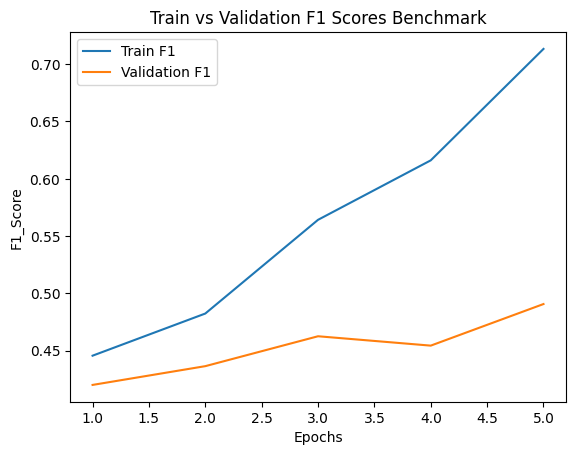

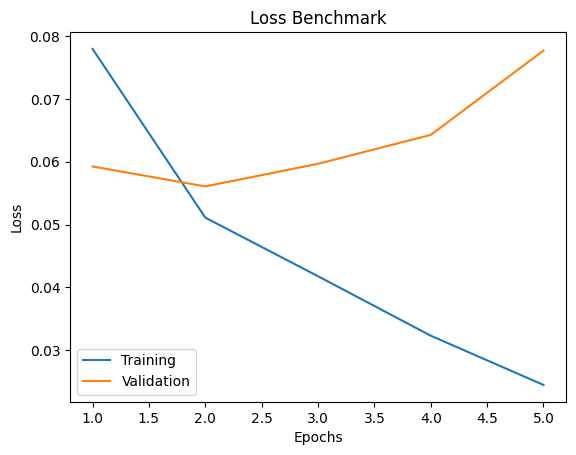

In [ ]:
# Saving both train and val scores
f1_train_scores_benchmark = f1_callback.train_f1_scores[-NUM_EPOCHS:]
f1_val_scores_benchmark = f1_callback.val_f1_scores[-NUM_EPOCHS:]
f1_callback.train_f1_scores = []
f1_callback.val_f1_scores = []

# Fully-Connected NN Model
plot_f1(f1_train_scores_benchmark, f1_val_scores_benchmark, "Train vs Validation F1 Scores Benchmark")
plot_loss(history_benchmark, "Loss Benchmark")

#### **Baseline Models (without Regularization)**

> The models in this project are designed following simple heuristics, keeping the architecture straightforward due to the large number of sequences. Evaluation on both the training and validation sets is performed using **Macro F1 Score**, a more reliable metric for imbalanced data compared to accuracy. Although accuracy remains consistently high (around 99% for each model, not shown in the notebook), it is not reported here, as it does not provide meaningful insights in this context.

> The chosen models are recurrent neural networks (RNNs), which are well-suited for tasks that use sequences and texts in general:
  - LSTM
  - GRU
  - Bidirectional LSTM
  - Bidirectional GRU

> One layer has been used, with 64 units, close to the embedding output dimension.

##### **LSTM**

> LSTM uses tanh activation function. The rest is the same as the Benchmark model.

In [ ]:
# Define LSTM model
lstm_model = Sequential()

# Embedding layer
lstm_model.add(Embedding(input_dim=len(vocab), output_dim=OUTPUT_DIM))

# LSTM layers
lstm_model.add(LSTM(64, activation='tanh'))  # LSTM Layer

# Fully Connected Layers
lstm_model.add(Dense(6, activation='sigmoid'))  # 6 labels, sigmoid for multi-label

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history_lstm = lstm_model.fit(X_train,
                              y_train,
                              epochs=NUM_EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_val, y_val),
                              callbacks=[f1_callback])

Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Epoch 1 - Train Macro F1-score: 0.0244, Val Macro F1-score: 0.0233
998/998 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - loss: 0.1658 - val_loss: 0.1414
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Epoch 2 - Train Macro F1-score: 0.0266, Val Macro F1-score: 0.0221
998/998 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.1396 - val_loss: 0.1413
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Epoch 3 - Train Macro F1-score: 0.0339, Val Macro F1-score: 0.0327
998/998 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - loss: 0.1416 - val_loss: 0.1406
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Epoch 4 - Train Macro F1-score: 0.0306, Val Macro F1-score: 0.0301
998/998 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - loss: 0.1378 - val_loss: 0.1405
Epoch 5/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 50)             │         500,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,589,642 (6.06 MB)

 Trainable params: 529,880 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,059,762 (4.04 MB)

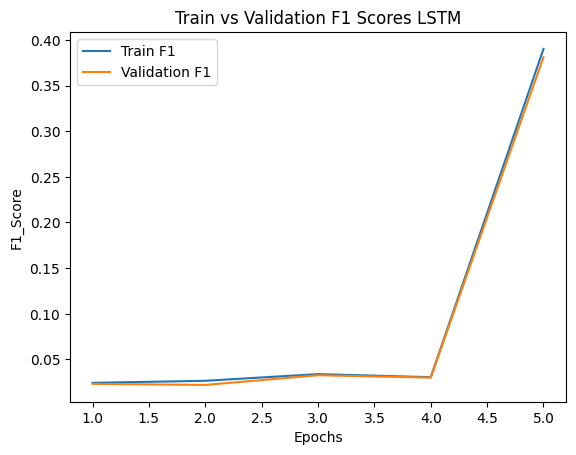

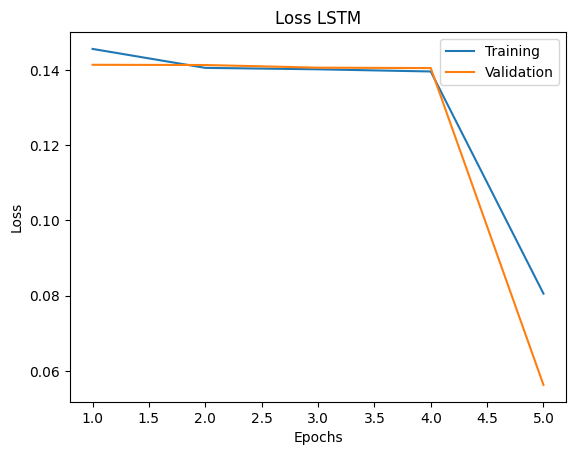

In [ ]:
# Saving both train and val scores
f1_train_scores_lstm = f1_callback.train_f1_scores[-NUM_EPOCHS:]
f1_val_scores_lstm = f1_callback.val_f1_scores[-NUM_EPOCHS:]
f1_callback.train_f1_scores = []
f1_callback.val_f1_scores = []

# Non-regularized Model
plot_f1(f1_train_scores_lstm, f1_val_scores_lstm, "Train vs Validation F1 Scores LSTM")
plot_loss(history_lstm, "Loss LSTM")

> The training plot show the differences between train and validation data performances. The model seems to struggle to converge until the last epoch, where the performances start to rise. Probably for this type of model, the number of epochs should be increased at least to 10.

##### **LSTM Bidirectional**

> LSTM Bidirectional captures both past and future context, making it more effective for understanding dependencies in text comments.

In [ ]:
# Define LSTM Bidirectional model
lstm_bi_model = Sequential()

# Embedding layer
lstm_bi_model.add(Embedding(input_dim=len(vocab), output_dim=OUTPUT_DIM))

# LSTM layers
lstm_bi_model.add(Bidirectional(LSTM(64, activation='tanh')))  # LSTM Layer

# Fully Connected Layers
lstm_bi_model.add(Dense(6, activation='sigmoid'))  # 6 labels, sigmoid for multi-label

# Compile the model
lstm_bi_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history_lstm_bi = lstm_bi_model.fit(X_train,
                                    y_train,
                                    epochs=NUM_EPOCHS,
                                    batch_size=BATCH_SIZE,
                                    validation_data=(X_val, y_val),
                                    callbacks=[f1_callback])

Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step

Epoch 1 - Train Macro F1-score: 0.3990, Val Macro F1-score: 0.3930
998/998 ━━━━━━━━━━━━━━━━━━━━ 76s 72ms/step - loss: 0.1287 - val_loss: 0.0528
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step

Epoch 2 - Train Macro F1-score: 0.4516, Val Macro F1-score: 0.4380
998/998 ━━━━━━━━━━━━━━━━━━━━ 73s 74ms/step - loss: 0.0514 - val_loss: 0.0505
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Epoch 3 - Train Macro F1-score: 0.4280, Val Macro F1-score: 0.4114
998/998 ━━━━━━━━━━━━━━━━━━━━ 69s 61ms/step - loss: 0.0460 - val_loss: 0.0500
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Epoch 4 - Train Macro F1-score: 0.4645, Val Macro F1-score: 0.4375
998/998 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 0.0431 - val_loss: 0.0499
Epoch 5/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
lstm_bi_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 200, 50)             │         500,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          58,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,679,114 (6.41 MB)

 Trainable params: 559,704 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,119,410 (4.27 MB)

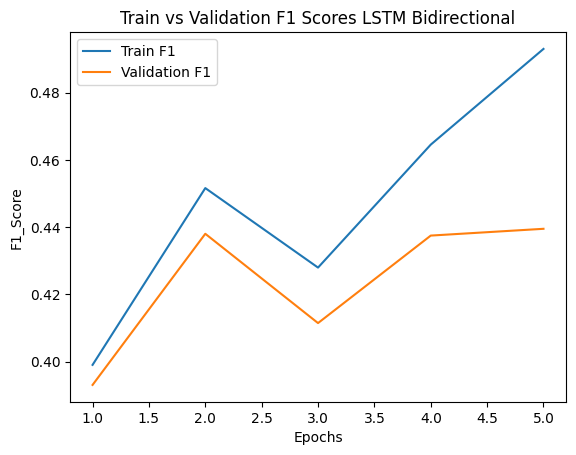

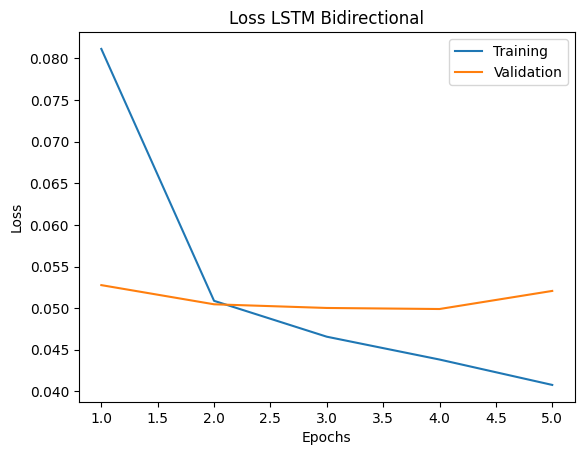

In [ ]:
# Saving both train and val scores
f1_train_scores_lstm_bi = f1_callback.train_f1_scores[-NUM_EPOCHS:]
f1_val_scores_lstm_bi = f1_callback.val_f1_scores[-NUM_EPOCHS:]
f1_callback.train_f1_scores = []
f1_callback.val_f1_scores = []

# Non-regularized Model
plot_f1(f1_train_scores_lstm_bi, f1_val_scores_lstm_bi, "Train vs Validation F1 Scores LSTM Bidirectional")
plot_loss(history_lstm_bi, "Loss LSTM Bidirectional")

> The bi-directional LSTM shows improvements compared to the baseline LSTM, with overall better performances and a much smoother plot, converging already with 2 epochs regarding the validation data. There are also some signs of overfitting, looking at the loss of train and validation data.

##### **GRU**

> GRU is useful for comparison with LSTM in text comment datasets.

> GRU has fewer parameters due to its simplified architecture with only two gates (update and reset), making it more efficient while retaining comparable performance.

In [ ]:
# Define GRU model
gru_model = Sequential()

# Embedding layer
gru_model.add(Embedding(input_dim=len(vocab), output_dim=OUTPUT_DIM))

# GRU layers
gru_model.add(GRU(64, activation='tanh'))  # GRU Layer

# Fully Connected Layers
gru_model.add(Dense(6, activation='sigmoid'))  # 6 labels, sigmoid for multi-label

# Compile the model
gru_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history_gru = gru_model.fit(X_train,
                            y_train,
                            epochs=NUM_EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_val, y_val),
                            callbacks=[f1_callback])

Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Epoch 1 - Train Macro F1-score: 0.4190, Val Macro F1-score: 0.4130
998/998 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - loss: 0.1504 - val_loss: 0.0540
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Epoch 2 - Train Macro F1-score: 0.4275, Val Macro F1-score: 0.4198
998/998 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.0496 - val_loss: 0.0494
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Epoch 3 - Train Macro F1-score: 0.4773, Val Macro F1-score: 0.4489
998/998 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - loss: 0.0454 - val_loss: 0.0498
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Epoch 4 - Train Macro F1-score: 0.5124, Val Macro F1-score: 0.4629
998/998 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - loss: 0.0409 - val_loss: 0.0495
Epoch 5/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
gru_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 200, 50)             │         500,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          22,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,568,138 (5.98 MB)

 Trainable params: 522,712 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,045,426 (3.99 MB)

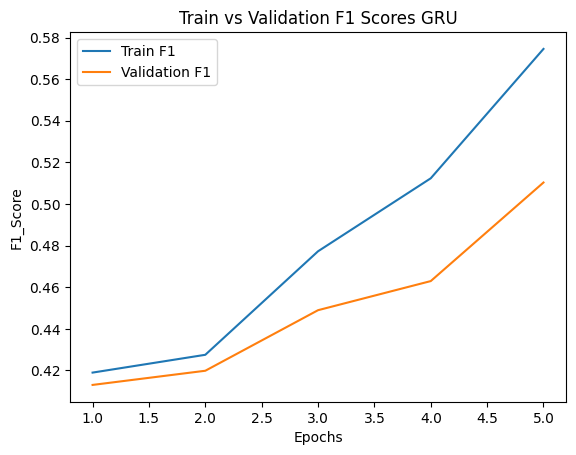

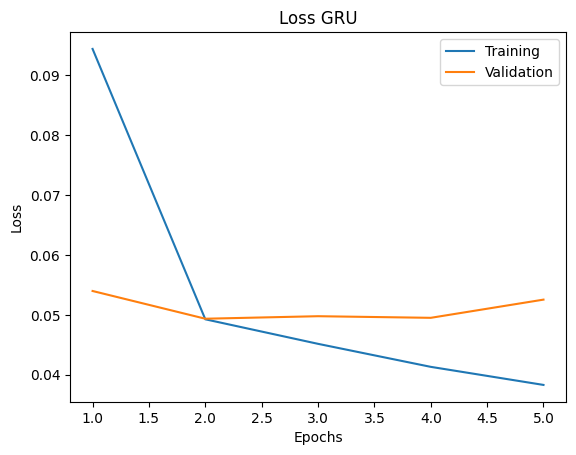

In [ ]:
# Saving both train and val scores
f1_train_scores_gru = f1_callback.train_f1_scores[-NUM_EPOCHS:]
f1_val_scores_gru = f1_callback.val_f1_scores[-NUM_EPOCHS:]
f1_callback.train_f1_scores = []
f1_callback.val_f1_scores = []

# Non-regularized Model
plot_f1(f1_train_scores_gru, f1_val_scores_gru, "Train vs Validation F1 Scores GRU")
plot_loss(history_gru, "Loss GRU")

> The baseline GRU model shows similar performances to the bi-directional LSTM, meaning that it could be a good alternative to the LSTM models. The overfitting is also visible in the loss plot.

##### **GRU Bidirectional**

> Like for LSTM Bidirectional, GRU Bidirectional has been tested.

In [ ]:
# Define GRU Bidirectional model
gru_bi_model = Sequential()

# Embedding layer
gru_bi_model.add(Embedding(input_dim=len(vocab), output_dim=OUTPUT_DIM))

# GRU layers
gru_bi_model.add(Bidirectional(GRU(64, activation='tanh')))  # GRU Layer

# Fully Connected Layers
gru_bi_model.add(Dense(6, activation='sigmoid'))  # 6 labels, sigmoid for multi-label

# Compile the model
gru_bi_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history_gru_bi = gru_bi_model.fit(X_train,
                                  y_train,
                                  epochs=NUM_EPOCHS,
                                  batch_size=BATCH_SIZE,
                                  validation_data=(X_val, y_val),
                                  callbacks=[f1_callback])

Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Epoch 1 - Train Macro F1-score: 0.4387, Val Macro F1-score: 0.4275
998/998 ━━━━━━━━━━━━━━━━━━━━ 71s 68ms/step - loss: 0.1189 - val_loss: 0.0516
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Epoch 2 - Train Macro F1-score: 0.4521, Val Macro F1-score: 0.4369
998/998 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - loss: 0.0480 - val_loss: 0.0500
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Epoch 3 - Train Macro F1-score: 0.4578, Val Macro F1-score: 0.4348
998/998 ━━━━━━━━━━━━━━━━━━━━ 87s 57ms/step - loss: 0.0443 - val_loss: 0.0495
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step

Epoch 4 - Train Macro F1-score: 0.5142, Val Macro F1-score: 0.4708
998/998 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - loss: 0.0413 - val_loss: 0.0497
Epoch 5/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
gru_bi_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 200, 50)             │         500,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          44,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,636,106 (6.24 MB)

 Trainable params: 545,368 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,090,738 (4.16 MB)

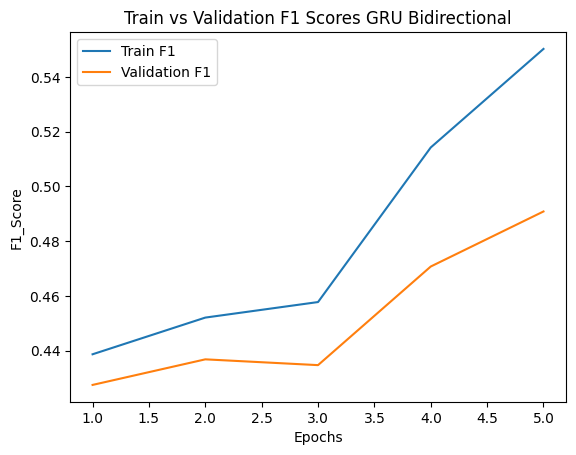

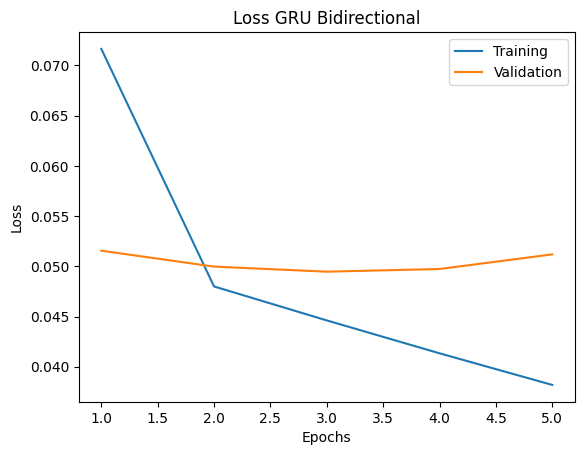

In [ ]:
# Saving both train and val scores
f1_train_scores_gru_bi = f1_callback.train_f1_scores[-NUM_EPOCHS:]
f1_val_scores_gru_bi = f1_callback.val_f1_scores[-NUM_EPOCHS:]
f1_callback.train_f1_scores = []
f1_callback.val_f1_scores = []

# Non-regularized Model
plot_f1(f1_train_scores_gru_bi, f1_val_scores_gru_bi, "Train vs Validation F1 Scores GRU Bidirectional")
plot_loss(history_gru_bi, "Loss GRU Bidirectional")

> GRU Bidirectional shows the best perfomances overall, compared to the previous models, but also the most overfitting (even if the losses are really low).

> The next attempt will be to try and regularize the two bi-directional models, as they are overall the best ones.

#### **Regularized Models**

> The regularization process has been kept rather simple, as the loss is overall low, but the aim is to both reduce the difference between the F1 Scores and losses in train and validation.
  - **Dropout (0.3)** was added to the models to prevent overfitting by randomly deactivating neurons during training.  
  - An **adaptive learning rate** (ReduceLROnPlateau) reduces the learning rate when validation loss plateaus, improving convergence.  
  - **Early stopping** halts training when validation loss stops improving, restoring the best weights to prevent overfitting.

##### **LSTM Bidirectional Regularized**

In [ ]:
# Define LSTM Bidirectional Regularized model
lstm_bi_regularized_model = Sequential()

# Embedding layer
lstm_bi_regularized_model.add(Embedding(input_dim=len(vocab), output_dim=OUTPUT_DIM))

# LSTM layers
lstm_bi_regularized_model.add(Bidirectional(LSTM(64, activation='tanh', dropout=0.3)))  # LSTM Layer

# Fully Connected Layers
lstm_bi_regularized_model.add(Dense(6, activation='sigmoid'))  # 6 labels, sigmoid for multi-label

# Compile the model
lstm_bi_regularized_model.compile(optimizer='adam', loss='binary_crossentropy')

# Callback for adaptive LR
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Callback for Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)

# Train the model
history_lstm_bi_regularized = lstm_bi_regularized_model.fit(X_train,
                                                            y_train,
                                                            epochs=NUM_EPOCHS,
                                                            batch_size=BATCH_SIZE,
                                                            validation_data=(X_val, y_val),
                                                            callbacks=[f1_callback, lr_scheduler, early_stopping])

Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Epoch 1 - Train Macro F1-score: 0.3541, Val Macro F1-score: 0.3513
998/998 ━━━━━━━━━━━━━━━━━━━━ 69s 63ms/step - loss: 0.1354 - val_loss: 0.0719 - learning_rate: 0.0010
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Epoch 2 - Train Macro F1-score: 0.3932, Val Macro F1-score: 0.3830
998/998 ━━━━━━━━━━━━━━━━━━━━ 75s 59ms/step - loss: 0.0578 - val_loss: 0.0539 - learning_rate: 0.0010
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step

Epoch 3 - Train Macro F1-score: 0.4473, Val Macro F1-score: 0.4316
998/998 ━━━━━━━━━━━━━━━━━━━━ 96s 73ms/step - loss: 0.0487 - val_loss: 0.0518 - learning_rate: 0.0010
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Epoch 4 - Train Macro F1-score: 0.4556, Val Macro F1-score: 0.4375
998/998 ━━━━━━━━━━━━━━━━━━━━ 66s 57ms/step - 

In [ ]:
lstm_bi_regularized_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 50)             │         500,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          58,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,679,114 (6.41 MB)

 Trainable params: 559,704 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,119,410 (4.27 MB)

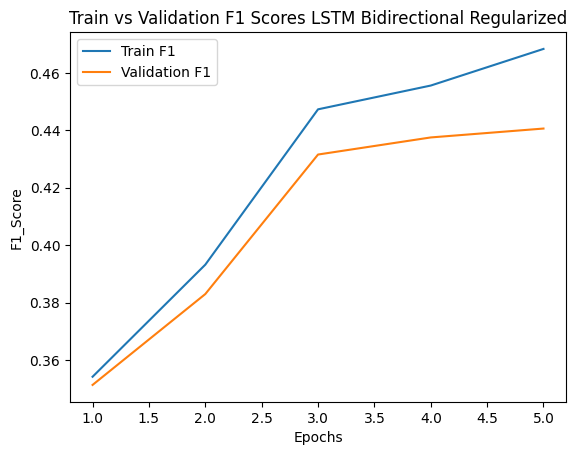

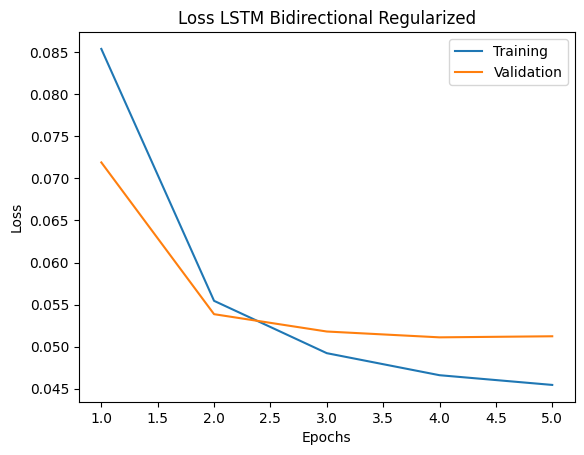

In [ ]:
# Saving both train and val scores
f1_train_scores_lstm_bi_regularized = f1_callback.train_f1_scores[-NUM_EPOCHS:]
f1_val_scores_lstm_bi_regularized = f1_callback.val_f1_scores[-NUM_EPOCHS:]
f1_callback.train_f1_scores = []
f1_callback.val_f1_scores = []

# Regularized Model
plot_f1(f1_train_scores_lstm_bi_regularized, f1_val_scores_lstm_bi_regularized, "Train vs Validation F1 Scores LSTM Bidirectional Regularized")
plot_loss(history_lstm_bi_regularized, "Loss LSTM Bidirectional Regularized")

> The regularized bi-directional LSTM show a much smoother curve, while retaining the performances of the non-regularized model. The losses show very similar values, with much less overfitting.

##### **GRU Bidirectional Regularized**

In [ ]:
# Define GRU Bidirectional Regularized model
gru_bi_regularized_model = Sequential()

# Embedding layer
gru_bi_regularized_model.add(Embedding(input_dim=len(vocab), output_dim=OUTPUT_DIM))

# GRU layers
gru_bi_regularized_model.add(Bidirectional(GRU(64, activation='tanh', dropout=0.3)))  # GRU Layer

# Fully Connected Layers
gru_bi_regularized_model.add(Dense(6, activation='sigmoid'))  # 6 labels, sigmoid for multi-label

# Compile the model
gru_bi_regularized_model.compile(optimizer='adam', loss='binary_crossentropy')

# Callback for adaptive LR
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Callback for Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
)

# Train the model
history_gru_bi_regularized = gru_bi_regularized_model.fit(X_train,
                                                          y_train,
                                                          epochs=NUM_EPOCHS,
                                                          batch_size=BATCH_SIZE,
                                                          validation_data=(X_val, y_val),
                                                          callbacks=[f1_callback, lr_scheduler, early_stopping])

Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Epoch 1 - Train Macro F1-score: 0.4374, Val Macro F1-score: 0.4306
998/998 ━━━━━━━━━━━━━━━━━━━━ 72s 69ms/step - loss: 0.1236 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step

Epoch 2 - Train Macro F1-score: 0.4327, Val Macro F1-score: 0.4167
998/998 ━━━━━━━━━━━━━━━━━━━━ 73s 73ms/step - loss: 0.0477 - val_loss: 0.0496 - learning_rate: 0.0010
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step

Epoch 3 - Train Macro F1-score: 0.4691, Val Macro F1-score: 0.4486
998/998 ━━━━━━━━━━━━━━━━━━━━ 69s 60ms/step - loss: 0.0451 - val_loss: 0.0504 - learning_rate: 0.0010
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

Epoch 4 - Train Macro F1-score: 0.4800, Val Macro F1-score: 0.4431
998/998 ━━━━━━━━━━━━━━━━━━━━ 78s 56ms/step - 

In [ ]:
gru_bi_regularized_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 50)             │         500,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          44,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,636,106 (6.24 MB)

 Trainable params: 545,368 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,090,738 (4.16 MB)

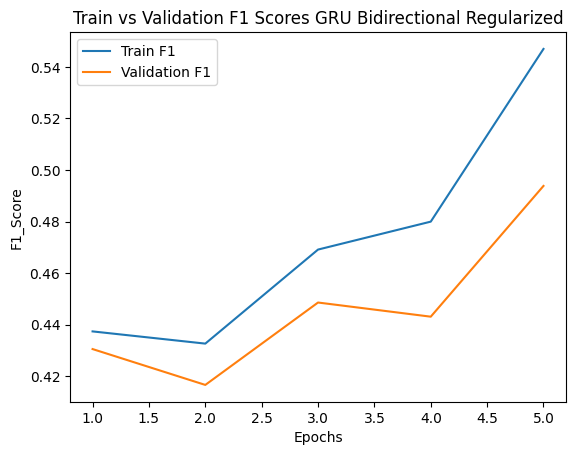

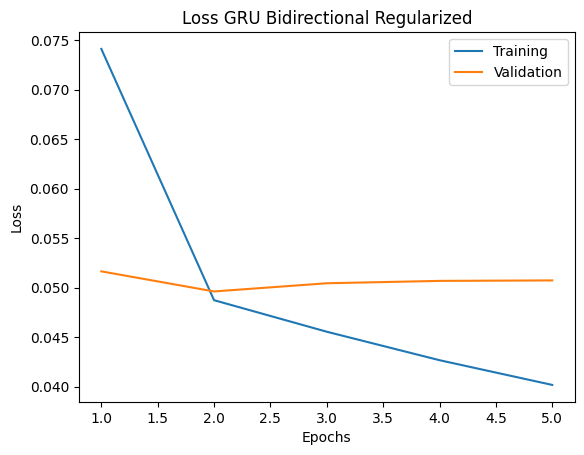

In [ ]:
# Saving both train and val scores
f1_train_scores_gru_bi_regularized = f1_callback.train_f1_scores[-NUM_EPOCHS:]
f1_val_scores_gru_bi_regularized = f1_callback.val_f1_scores[-NUM_EPOCHS:]
f1_callback.train_f1_scores = []
f1_callback.val_f1_scores = []

# Regularized Model
plot_f1(f1_train_scores_gru_bi_regularized, f1_val_scores_gru_bi_regularized, "Train vs Validation F1 Scores GRU Bidirectional Regularized")
plot_loss(history_gru_bi_regularized, "Loss GRU Bidirectional Regularized")

> The bi-directional GRU regularized model presents an interesting trend, as the best epoch selected is the second one, where overfitting is minimized, while maintaining performance similar to the non-regularized model. Additionally, there is a noticeable spike in F1 scores in the final epoch, which may indicate a temporary improvement due to random fluctuations.

##### **Ensemble using Average Predictions**

> Finally, the regularized models were used to create a simple ensemble by averaging their predictions. While ensembling typically yields better results when combining diverse models, it is still worth evaluating whether this approach provides any improvements, particularly on the test data, which will be analyzed later.

In [ ]:
# Using the predictions from the two regularized models
ensemble_val_preds = ensemble_prediction(gru_bi_regularized_model, lstm_bi_regularized_model, X_val)

998/998 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


> Compared to the models analyzed before, the ensemble will be quickly evaluated in the following code using the validation data on the ROC AUC Mean.

> Then, the ensemble will be evaluated like the other models in the next sections.

In [ ]:
# Calculate the mean ROC AUC using each class
mean_auc_ensemble_val = mean_columnwise_roc_auc(y_val, ensemble_val_preds)

print(f"\n[Ensemble] Mean Column-wise ROC AUC: {mean_auc_ensemble_val:.4f}")

ROC AUC for each class:
Class 1: 0.9729
Class 2: 0.9881
Class 3: 0.9895
Class 4: 0.9526
Class 5: 0.9806
Class 6: 0.9592

[Ensemble] Mean Column-wise ROC AUC: 0.9738


> The ROC AUC value can be compared when using the test data, to see the difference between the performance on validation and test.

### **Models Evaluation**

> On the Test Set, F1-Score is evaluated because it balances precision and recall, making it more reliable than accuracy when dealing with class imbalances, ensuring that both minority and majority classes are properly evaluated.

> We also evaluate ROC AUC mean like in the Kaggle challenge. The ROC AUC mean for the 6 labels provides an overall measure of the model's ability to distinguish between positive and negative cases across all classes. Since it's a multi-label classification problem, each label has its own ROC curve, and taking the mean ensures that performance is evaluated across all labels, preventing dominance by majority classes.

#### **Test Set Preprocessing**

> First of all, before evaluating on the test set, we must re-apply all the operations applied on the training set.

In [ ]:
# Copy the test df
test_merged_df_copy = test_merged_df.copy()

# Apply text processing and keep the list of lemmatized tokens
test_merged_df_copy['comment_tokens'] = test_merged_df_copy['comment_text'].apply(preprocess_text)

# Create sequences
test_merged_df_copy['sequences'] = test_merged_df_copy['comment_tokens'].apply(lambda tokens: text_to_sequence(tokens, vocab))
X_test_seq = test_merged_df_copy['sequences'].tolist()

In [ ]:
# Preview of the new test set
test_merged_df_copy.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_tokens,sequences
0,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0,"[thank, understanding, think, highly, revert, without, discussion]","[51, 870, 10, 890, 270, 89, 49]"


In [ ]:
# Pad sequences to ensure they all have the same length
X_test_padded = pad_sequences(X_test_seq, maxlen=200, padding='post')

In [ ]:
# X_test and y_test
X_test = X_test_padded
y_test = test_merged_df_copy[test_merged_df_copy.columns[2:8]]
y_test_np = np.array(y_test)  # NumPy array

#### **Initial Benchmark**

> The ROC AUC scores per class range from 0.9371 to 0.9723, with a mean ROC AUC of 0.9573, indicating the model ranks positive cases well.

> The test loss is 0.0963, showing how well the model's predictions align with actual labels.

> The F1-scores vary significantly across classes, from 0.2008 to 0.6674, meaning some labels are predicted better than others.

> The macro F1-score is 0.4696, much lower than the ROC AUC, suggesting that while the model ranks well, it struggles with precise classification due to class imbalance.

In [ ]:
# We need the predictions
y_pred_probs_test_benchmark_model = benchmark_model.predict(X_test)

# Calculate the mean ROC AUC using each class
mean_auc_benchmark = mean_columnwise_roc_auc(y_test, y_pred_probs_test_benchmark_model)

print(f"\n[Benchmark NN] Mean Column-wise ROC AUC: {mean_auc_benchmark:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
ROC AUC for each class:
Class 1: 0.9371
Class 2: 0.9780
Class 3: 0.9544
Class 4: 0.9723
Class 5: 0.9453
Class 6: 0.9568

[Benchmark NN] Mean Column-wise ROC AUC: 0.9573


In [ ]:
# Predictions for the test set
y_pred = (benchmark_model.predict(X_test) > 0.5).astype("int32")

# Convert to NumPy array
y_pred_np = np.array(y_pred)

# Evaluate the model on the test set to calculate the loss
test_loss_benchmark = benchmark_model.evaluate(X_test, y_test, verbose=0)
print(f"\n[Benchmark NN] Test Loss: {test_loss_benchmark:.4f}")

# Evaluating F1-score for each class
print("\n[Benchmark NN] Test F1 Scores per class:")
for i in range(y_test_np.shape[1]):
    f1 = f1_score(y_test_np[:, i], y_pred_np[:, i])
    print(f"Class {i+1}: {f1:.4f}")

# Macro average F1-score
macro_f1_benchmark = f1_score(y_test_np, y_pred_np, average='macro')
print(f"\n[Benchmark NN] Test Macro F1-score: {macro_f1_benchmark:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

[Benchmark NN] Test Loss: 0.0963

[Benchmark NN] Test F1 Scores per class:
Class 1: 0.6602
Class 2: 0.3559
Class 3: 0.6674
Class 4: 0.2008
Class 5: 0.5998
Class 6: 0.3337

[Benchmark NN] Test Macro F1-score: 0.4696


#### **Baseline Models (without Regularization)**

##### **LSTM**

> ROC AUC scores range from 0.9417 to 0.9808, with a mean ROC AUC of 0.9595, slightly better than the benchmark model, indicating good ranking performance.

> The test loss is 0.0731, lower than the benchmark, suggesting better alignment between predictions and actual labels.

> The F1-scores show significant class imbalance, with one class having 0.0008, meaning the model struggles to predict certain labels.

> The macro F1-score is 0.3446, lower than the benchmark, indicating that while LSTM ranks well (high ROC AUC), its actual classification is weaker, particularly for less frequent labels.

In [ ]:
# We need the predictions
y_pred_probs_test_lstm_model = lstm_model.predict(X_test)

# Calculate the mean ROC AUC using each class
mean_auc_lstm = mean_columnwise_roc_auc(y_test, y_pred_probs_test_lstm_model)

print(f"\n[LSTM] Mean Column-wise ROC AUC: {mean_auc_lstm:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
ROC AUC for each class:
Class 1: 0.9571
Class 2: 0.9808
Class 3: 0.9718
Class 4: 0.9444
Class 5: 0.9614
Class 6: 0.9417

[LSTM] Mean Column-wise ROC AUC: 0.9595


In [ ]:
# Predictions for the test set
y_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")

# Convert to NumPy array
y_pred_np = np.array(y_pred)

# Evaluate the model on the test set to calculate the loss
test_loss_lstm = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\n[LSTM] Test Loss: {test_loss_lstm:.4f}")

# Evaluating F1-score for each class
print("\n[LSTM] Test F1 Scores per class:")
for i in range(y_test_np.shape[1]):
    f1 = f1_score(y_test_np[:, i], y_pred_np[:, i])
    print(f"Class {i+1}: {f1:.4f}")

# Macro average F1-score
macro_f1_lstm = f1_score(y_test_np, y_pred_np, average='macro')
print(f"\n[LSTM] Test Macro F1-score: {macro_f1_lstm:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

[LSTM] Test Loss: 0.0731

[LSTM] Test F1 Scores per class:
Class 1: 0.6791
Class 2: 0.1045
Class 3: 0.6858
Class 4: 0.0000
Class 5: 0.5928
Class 6: 0.0056

[LSTM] Test Macro F1-score: 0.3446


##### **LSTM Bidirectional**

> ROC AUC scores range from 0.9530 to 0.9849, with a mean ROC AUC of 0.9637, showing slightly better ranking ability than the standard LSTM.

> The test loss is 0.0843, lower than the regular LSTM, indicating improved prediction alignment with actual labels.

> The F1-scores show similar class imbalance issues, with one class having 0.0000, meaning the model fails to predict it at all.

> The macro F1-score is 0.3817, slightly better than the regular LSTM but still low, suggesting that despite improved ranking (ROC AUC), classification performance remains weak for certain labels.

In [ ]:
# We need the predictions
y_pred_probs_test_lstm_bi_model = lstm_bi_model.predict(X_test)

# Calculate the mean ROC AUC using each class
mean_auc_lstm_bi = mean_columnwise_roc_auc(y_test, y_pred_probs_test_lstm_bi_model)

print(f"\n[LSTM Bidirectional] Mean Column-wise ROC AUC: {mean_auc_lstm_bi:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step
ROC AUC for each class:
Class 1: 0.9544
Class 2: 0.9849
Class 3: 0.9732
Class 4: 0.9535
Class 5: 0.9629
Class 6: 0.9530

[LSTM Bidirectional] Mean Column-wise ROC AUC: 0.9637


In [ ]:
# Predictions for the test set
y_pred = (lstm_bi_model.predict(X_test) > 0.5).astype("int32")

# Convert to NumPy array
y_pred_np = np.array(y_pred)

# Evaluate the model on the test set to calculate the loss
test_loss_lstm_bi = lstm_bi_model.evaluate(X_test, y_test, verbose=0)
print(f"\n[LSTM Bidirectional] Test Loss: {test_loss_lstm_bi:.4f}")

# Evaluating F1-score for each class
print("\n[LSTM Bidirectional] Test F1 Scores per class:")
for i in range(y_test_np.shape[1]):
    f1 = f1_score(y_test_np[:, i], y_pred_np[:, i])
    print(f"Class {i+1}: {f1:.4f}")

# Macro average F1-score
macro_f1_lstm_bi = f1_score(y_test_np, y_pred_np, average='macro')
print(f"\n[LSTM Bidirectional] Test Macro F1-score: {macro_f1_lstm_bi:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

[LSTM Bidirectional] Test Loss: 0.0843

[LSTM Bidirectional] Test F1 Scores per class:
Class 1: 0.6184
Class 2: 0.3620
Class 3: 0.6783
Class 4: 0.0000
Class 5: 0.6093
Class 6: 0.0220

[LSTM Bidirectional] Test Macro F1-score: 0.3817


##### **GRU**

> ROC AUC scores range from 0.9520 to 0.9852, with a mean ROC AUC of 0.9663, showing strong ranking performance, slightly better than LSTM.

> The test loss is 0.0887, indicating decent prediction alignment with actual labels, though slightly higher than LSTM.

> The F1-scores are still inconsistent across classes, with one class scoring 0.0008, meaning it is not well predicted.

> The macro F1-score is 0.4585, higher than both LSTM models, suggesting GRU performs better at classification while still facing issues with class imbalance.

In [ ]:
# We need the predictions
y_pred_probs_test_gru_model = gru_model.predict(X_test)

# Calculate the mean ROC AUC using each class
mean_auc_gru = mean_columnwise_roc_auc(y_test, y_pred_probs_test_gru_model)

print(f"\n[GRU] Mean Column-wise ROC AUC: {mean_auc_gru:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
ROC AUC for each class:
Class 1: 0.9520
Class 2: 0.9852
Class 3: 0.9714
Class 4: 0.9621
Class 5: 0.9627
Class 6: 0.9647

[GRU] Mean Column-wise ROC AUC: 0.9663


In [ ]:
# Predictions for the test set
y_pred = (gru_model.predict(X_test) > 0.5).astype("int32")

# Convert to NumPy array
y_pred_np = np.array(y_pred)

# Evaluate the model on the test set to calculate the loss
test_loss_gru = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"\n[GRU] Test Loss: {test_loss_gru:.4f}")

# Evaluating F1-score for each class
print("\n[GRU] Test F1 Scores per class:")
for i in range(y_test_np.shape[1]):
    f1 = f1_score(y_test_np[:, i], y_pred_np[:, i])
    print(f"Class {i+1}: {f1:.4f}")

# Macro average F1-score
macro_f1_gru = f1_score(y_test_np, y_pred_np, average='macro')
print(f"\n[GRU] Test Macro F1-score: {macro_f1_gru:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

[GRU] Test Loss: 0.0887

[GRU] Test F1 Scores per class:
Class 1: 0.6234
Class 2: 0.3785
Class 3: 0.6734
Class 4: 0.0000
Class 5: 0.6073
Class 6: 0.4682

[GRU] Test Macro F1-score: 0.4585


##### **GRU Bidirectional**

> ROC AUC scores range from 0.9536 to 0.9846, with a mean ROC AUC of 0.9678, slightly improving on the standard GRU model.

> The test loss is 0.0811, lower than GRU, indicating better prediction accuracy.

> The F1-scores show some improvement, but class imbalance remains, with scores ranging from 0.3415 to 0.6663.

> The macro F1-score is 0.4470, higher than the standard GRU, showing that the bidirectional approach helps improve classification performance while maintaining strong ranking ability.

In [ ]:
# We need the predictions
y_pred_probs_test_gru_bi_model = gru_bi_model.predict(X_test)

# Calculate the mean ROC AUC using each class
mean_auc_gru_bi = mean_columnwise_roc_auc(y_test, y_pred_probs_test_gru_bi_model)

print(f"\n[GRU Bidirectional] Mean Column-wise ROC AUC: {mean_auc_gru_bi:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step
ROC AUC for each class:
Class 1: 0.9536
Class 2: 0.9846
Class 3: 0.9714
Class 4: 0.9638
Class 5: 0.9645
Class 6: 0.9689

[GRU Bidirectional] Mean Column-wise ROC AUC: 0.9678


In [ ]:
# Predictions for the test set
y_pred = (gru_bi_model.predict(X_test) > 0.5).astype("int32")

# Convert to NumPy array
y_pred_np = np.array(y_pred)

# Evaluate the model on the test set to calculate the loss
test_loss_gru_bi = gru_bi_model.evaluate(X_test, y_test, verbose=0)
print(f"\n[GRU Bidirectional] Test Loss: {test_loss_gru_bi:.4f}")

# Evaluating F1-score for each class
print("\n[GRU Bidirectional] Test F1 Scores per class:")
for i in range(y_test_np.shape[1]):
    f1 = f1_score(y_test_np[:, i], y_pred_np[:, i])
    print(f"Class {i+1}: {f1:.4f}")

# Macro average F1-score
macro_f1_gru_bi = f1_score(y_test_np, y_pred_np, average='macro')
print(f"\n[GRU Bidirectional] Test Macro F1-score: {macro_f1_gru_bi:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step

[GRU Bidirectional] Test Loss: 0.0811

[GRU Bidirectional] Test F1 Scores per class:
Class 1: 0.6265
Class 2: 0.3415
Class 3: 0.6663
Class 4: 0.0185
Class 5: 0.6245
Class 6: 0.4048

[GRU Bidirectional] Test Macro F1-score: 0.4470


#### **Regularized Models**

##### **LSTM Bidirectional Regularized**

> ROC AUC scores range from 0.9458 to 0.9829, with a mean ROC AUC of 0.9615, slightly lower than the non-regularized LSTM bidirectional model.

> The test loss is 0.0792, showing improved prediction stability compared to the non-regularized version.

> F1-scores remain inconsistent, with one class scoring 0.0000, indicating that some labels are still not well predicted.

> The macro F1-score is 0.3667, slightly lower than the non-regularized version, meaning that regularization helped reduce overfitting but did not significantly improve classification performance.

In [ ]:
# We need the predictions
y_pred_probs_test_lstm_bi_regularized_model = lstm_bi_regularized_model.predict(X_test)

# Calculate the mean ROC AUC using each class
mean_auc_lstm_bi_regularized = mean_columnwise_roc_auc(y_test, y_pred_probs_test_lstm_bi_regularized_model)

print(f"\n[LSTM Bidirectional Regularized] Mean Column-wise ROC AUC: {mean_auc_lstm_bi_regularized:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step
ROC AUC for each class:
Class 1: 0.9571
Class 2: 0.9829
Class 3: 0.9729
Class 4: 0.9458
Class 5: 0.9635
Class 6: 0.9467

[LSTM Bidirectional Regularized] Mean Column-wise ROC AUC: 0.9615


In [ ]:
# Predictions for the test set
y_pred = (lstm_bi_regularized_model.predict(X_test) > 0.5).astype("int32")

# Convert to NumPy array
y_pred_np = np.array(y_pred)

# Evaluate the model on the test set to calculate the loss
test_loss_lstm_bi_regularized = lstm_bi_regularized_model.evaluate(X_test, y_test, verbose=0)
print(f"\n[LSTM Bidirectional Regularized] Test Loss: {test_loss_lstm_bi_regularized:.4f}")

# Evaluating F1-score for each class
print("\n[LSTM Bidirectional Regularized] Test F1 Scores per class:")
for i in range(y_test_np.shape[1]):
    f1 = f1_score(y_test_np[:, i], y_pred_np[:, i])
    print(f"Class {i+1}: {f1:.4f}")

# Macro average F1-score
macro_f1_lstm_bi_regularized = f1_score(y_test_np, y_pred_np, average='macro')
print(f"\n[LSTM Bidirectional Regularized] Test Macro F1-score: {macro_f1_lstm_bi_regularized:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step

[LSTM Bidirectional Regularized] Test Loss: 0.0792

[LSTM Bidirectional Regularized] Test F1 Scores per class:
Class 1: 0.6490
Class 2: 0.2729
Class 3: 0.6824
Class 4: 0.0000
Class 5: 0.5957
Class 6: 0.0000

[LSTM Bidirectional Regularized] Test Macro F1-score: 0.3667


##### **GRU Bidirectional Regularized**

> ROC AUC scores range from 0.9465 to 0.9834, with a mean ROC AUC of 0.9634, showing strong ranking performance, similar to the non-regularized GRU bidirectional model.

> The test loss is 0.0749, the lowest among all models so far, indicating stable and well-calibrated predictions.

> F1-scores remain uneven, with one class scoring 0.0000, meaning some labels are still not well captured by the model.

> The macro F1-score is 0.3705, slightly lower than the non-regularized version, suggesting that while regularization helped with overfitting, it did not significantly improve classification performance for the least frequent classes.

In [ ]:
# We need the predictions
y_pred_probs_test_gru_bi_regularized_model = gru_bi_regularized_model.predict(X_test)

# Calculate the mean ROC AUC using each class
mean_auc_gru_bi_regularized = mean_columnwise_roc_auc(y_test, y_pred_probs_test_gru_bi_regularized_model)

print(f"\n[GRU Bidirectional Regularized] Mean Column-wise ROC AUC: {mean_auc_gru_bi_regularized:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step
ROC AUC for each class:
Class 1: 0.9602
Class 2: 0.9834
Class 3: 0.9752
Class 4: 0.9465
Class 5: 0.9654
Class 6: 0.9497

[GRU Bidirectional Regularized] Mean Column-wise ROC AUC: 0.9634


In [ ]:
# Predictions for the test set
y_pred = (gru_bi_regularized_model.predict(X_test) > 0.5).astype("int32")

# Convert to NumPy array
y_pred_np = np.array(y_pred)

# Evaluate the model on the test set to calculate the loss
test_loss_gru_bi_regularized = gru_bi_regularized_model.evaluate(X_test, y_test, verbose=0)
print(f"\n[GRU Bidirectional Regularized] Test Loss: {test_loss_gru_bi_regularized:.4f}")

# Evaluating F1-score for each class
print("\n[GRU Bidirectional Regularized] Test F1 Scores per class:")
for i in range(y_test_np.shape[1]):
    f1 = f1_score(y_test_np[:, i], y_pred_np[:, i])
    print(f"Class {i+1}: {f1:.4f}")

# Macro average F1-score
macro_f1_gru_bi_regularized = f1_score(y_test_np, y_pred_np, average='macro')
print(f"\n[GRU Bidirectional Regularized] Test Macro F1-score: {macro_f1_gru_bi_regularized:.4f}")

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step

[GRU Bidirectional Regularized] Test Loss: 0.0749

[GRU Bidirectional Regularized] Test F1 Scores per class:
Class 1: 0.6518
Class 2: 0.2519
Class 3: 0.7027
Class 4: 0.0000
Class 5: 0.6164
Class 6: 0.0000

[GRU Bidirectional Regularized] Test Macro F1-score: 0.3705


##### **Ensemble using Average Predictions**

> ROC AUC scores range from 0.9501 to 0.9846, with a mean ROC AUC of 0.9643, showing that the ensemble approach maintains strong ranking performance.

> The test loss is 0.0754, indicating stable predictions, slightly lower than individual models.

> F1-scores remain inconsistent, with one class scoring 0.0000, meaning some labels are still difficult for the model to classify.

> The macro F1-score is 0.3734, which is similar to the regularized individual models, suggesting that ensembling helped with robustness but did not significantly improve classification performance.

In [ ]:
# Using the predictions from the two regularized models
ensemble_test_preds = ensemble_prediction(gru_bi_regularized_model, lstm_bi_regularized_model, X_test)

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step


In [ ]:
# Calculate the mean ROC AUC using each class
mean_auc_ensemble_test = mean_columnwise_roc_auc(y_test, ensemble_test_preds)

print(f"\n[Ensemble] Mean Column-wise ROC AUC: {mean_auc_ensemble_test:.4f}")

ROC AUC for each class:
Class 1: 0.9599
Class 2: 0.9846
Class 3: 0.9753
Class 4: 0.9503
Class 5: 0.9659
Class 6: 0.9501

[Ensemble] Mean Column-wise ROC AUC: 0.9643


In [ ]:
# Using binary crossentropy
loss_fn = BinaryCrossentropy()

# Getting the loss for the ensemble
final_loss = loss_fn(y_test, ensemble_test_preds)
print(f"\n[Ensemble] Test Loss: {final_loss:.4f}")


[Ensemble] Test Loss: 0.0754


In [ ]:
# Converting the ensemble predictions to binary (for F1-score calculation)
ensemble_test_preds_bin = (ensemble_test_preds > 0.5).astype("int32")

# Convert to NumPy array for evaluation
ensemble_test_preds_np = np.array(ensemble_test_preds_bin)
# Evaluating F1-score for each class
print("\n[Ensemble] Test F1 Scores per class:")
for i in range(y_test_np.shape[1]):
    f1 = f1_score(y_test_np[:, i], ensemble_test_preds_np[:, i])
    print(f"Class {i+1}: {f1:.4f}")

# Ensemble average F1-score
ensemble_f1 = f1_score(y_test_np, ensemble_test_preds_np, average='macro')
print(f"\n[Ensemble] Test Macro F1-score: {ensemble_f1:.4f}")


[Ensemble] Test F1 Scores per class:
Class 1: 0.6554
Class 2: 0.2676
Class 3: 0.7017
Class 4: 0.0000
Class 5: 0.6159
Class 6: 0.0000

[Ensemble] Test Macro F1-score: 0.3734


## **Kaggle Submission**

> To be able to perform a submission on the Kaggle competition, it is required to keep in the test set also the rows with labels = -1. They don't actually affect the score, which is the mean column-wise (every class) of the ROC AUC as done in the previous sections.

> In Kaggle competitions, the public score is based on a subset of the test set revealed during the competition, while the private score is calculated on the remaining hidden test data and determines the final rankings.

### **Useful functions**

In [ ]:
# Generate the csv for the Kaggle competition submission, using the whole test set with also -1 labels (which aren't scored)
def output_submission_file(sample_submission, model, filename, class_names, X_test_final):
  # Using the full test set for the prediction
  sample_submission_copy = sample_submission.copy()
  sample_submission_copy[class_names] = model.predict(X_test_final)

  # Saving on a csv file
  sample_submission_copy.to_csv(filename, index=False)

  print(f"Submission file: {filename}")

In [ ]:
# Generate the csv for the Kaggle competition submission, for the ensemble
def output_submission_file_from_preds(sample_submission, preds, class_names, filename):
    # Ensure the predictions are in the correct shape (should match the class_names length)
    assert preds.shape[1] == len(class_names), "Predictions shape does not match number of classes!"

    # Copy the sample submission and fill with the predicted values
    sample_submission_copy = sample_submission.copy()
    sample_submission_copy[class_names] = preds  # Using the provided preds directly

    # Saving the submission to a CSV file
    sample_submission_copy.to_csv(filename, index=False)

    print(f"Submission file saved: {filename}")


### **Full test set preparation**

> The entire test set is preprocessed, including rows with -1 labels, ensuring they remain in the dataset as required for Kaggle submission.

> Text is tokenized and converted into sequences, following the same preprocessing steps as the training data.

> Sequences are then padded to a fixed length of 200 tokens to maintain input consistency.

> The sample submission file is loaded to match Kaggle's required format.

In [ ]:
# Copy the test df
test_df_copy = test_df.copy()

# Apply text processing and keep the list of lemmatized tokens
test_df_copy['comment_tokens'] = test_df_copy['comment_text'].apply(preprocess_text)

# Create sequences
test_df_copy['sequences'] = test_df_copy['comment_tokens'].apply(lambda tokens: text_to_sequence(tokens, vocab))
X_test_seq_final = test_df_copy['sequences'].tolist()

# X_test_final: pad sequences to ensure they all have the same length
X_test_final = pad_sequences(X_test_seq_final, maxlen=200, padding='post')

In [ ]:
# For submission on Kaggle (challenge)
sample_submission = pd.read_csv("/content/drive/MyDrive/Progetto AML - Toxic Comments/Dataset/sample_submission.csv")

# Selecting the class names (for the prediction and submission file)
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### **Initial Benchmark**

> The initial benchmark model was submitted to Kaggle to establish a baseline performance for comparison with more advanced architectures.

**Performance on Kaggle**
  - Public Score: 0.95893
  - Private Score: 0.95695

> The benchmark model achieved a high ROC AUC, demonstrating strong ranking performance. However, its macro F1-score was relatively low, highlighting difficulties in handling class imbalance. This submission serves as a reference point to evaluate improvements made by more complex models like LSTM and GRU.

In [ ]:
output_submission_file(sample_submission, benchmark_model, 'test_NN_benchmark.csv', class_names, X_test_final)

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Submission file: test_NN_benchmark.csv


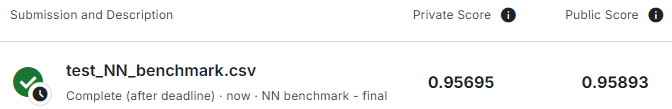

### **Without Regularization**

#### **LSTM predictions submission**

> The LSTM model was submitted to Kaggle to evaluate whether using a recurrent architecture improves performance over the benchmark fully connected model.  

**Performance on Kaggle**  
  - Public Score: 0.95882
  - Private Score: 0.95952  

> The ROC AUC scores are comparable to the benchmark, showing that LSTM maintains strong ranking performance. However, the macro F1-score remained low, indicating that while LSTM captures sequential dependencies better, it still struggles with class imbalance.

In [ ]:
output_submission_file(sample_submission, lstm_model, 'test_LSTM.csv', class_names, X_test_final)

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step
Submission file: test_LSTM.csv


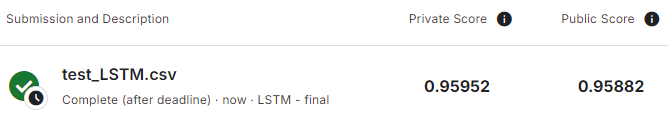

#### **LSTM Bidirectional predictions submission**

> The bidirectional LSTM model was submitted to Kaggle to assess whether processing text in both forward and backward directions improves performance over the standard LSTM.  

**Performance on Kaggle**  
  - Public Score: 0.96300  
  - Private Score: 0.96376  

> The ROC AUC scores show a noticeable improvement compared to the standard LSTM, indicating that bidirectional processing helps capture more contextual information. However, the macro F1-score remains low, suggesting that class imbalance is still an issue despite the increased model complexity.

In [ ]:
output_submission_file(sample_submission, lstm_bi_model, 'test_LSTM_Bidirectional.csv', class_names, X_test_final)

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step
Submission file: test_LSTM_Bidirectional.csv


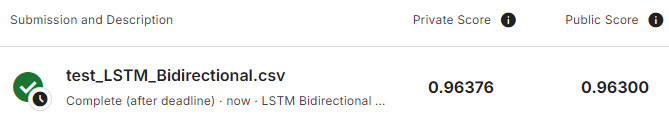

#### **GRU predictions submission**

> The GRU model was submitted to Kaggle to evaluate whether using a gated recurrent unit architecture provides advantages over LSTM in handling sequential text data.  

**Performance on Kaggle**  
  - Public Score: 0.96760  
  - Private Score: 0.96602  

> The ROC AUC scores show an improvement over both the standard and bidirectional LSTM models, indicating that GRU effectively captures dependencies in the data. Despite this, the macro F1-score remains low, suggesting that class imbalance continues to be a challenge.

In [ ]:
output_submission_file(sample_submission, gru_model, 'test_GRU.csv', class_names, X_test_final)

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step
Submission file: test_GRU.csv


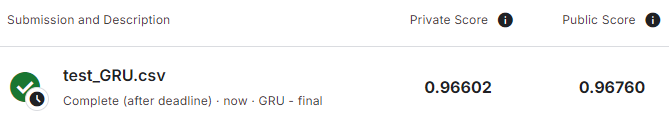

#### **GRU Bidirectional predictions submission**

> The bidirectional GRU model was submitted to Kaggle to determine whether processing text in both forward and backward directions enhances performance compared to the standard GRU.  

**Performance on Kaggle**  
  - Public Score: 0.97025  
  - Private Score: 0.96713  

> The ROC AUC scores show a further improvement over the standard GRU, suggesting that bidirectional processing helps capture richer contextual information. However, the macro F1-score remains low, indicating that class imbalance issues persist despite the stronger ranking performance.

In [ ]:
output_submission_file(sample_submission, gru_bi_model, 'test_GRU_Bidirectional.csv', class_names, X_test_final)

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step
Submission file: test_GRU_Bidirectional.csv


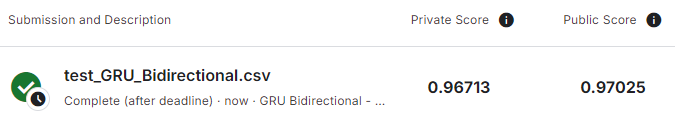

### **With Regularization**

#### **LSTM Bidirectional Regularized predictions submission**

> The regularized bidirectional LSTM model was submitted to Kaggle to assess whether adding dropout and other regularization techniques helps improve generalization compared to the non-regularized version.  

**Performance on Kaggle**  
  - Public Score: 0.96056  
  - Private Score: 0.96141  

> The ROC AUC scores show a slight decrease compared to the non-regularized bidirectional LSTM, suggesting that while regularization helps prevent overfitting, it may also slightly reduce ranking performance. The macro F1-score remains low, indicating that class imbalance remains a challenge.

In [ ]:
output_submission_file(sample_submission, lstm_bi_regularized_model, 'test_LSTM_Bidirectional_regularized.csv', class_names, X_test_final)

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step
Submission file: test_LSTM_Bidirectional_regularized.csv


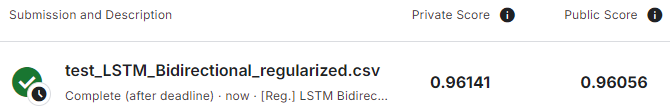

#### **GRU Bidirectional Regularized predictions submission**

> The regularized bidirectional GRU model was submitted to Kaggle to examine whether adding dropout and other regularization techniques improves generalization compared to the non-regularized bidirectional GRU.  

**Performance on Kaggle**  
  - Public Score: 0.96321  
  - Private Score: 0.96352  

> The ROC AUC scores show a slight decrease compared to the non-regularized bidirectional GRU, indicating that while regularization helps mitigate overfitting, it does not significantly enhance ranking performance. The macro F1-score remains low, meaning class imbalance is still a challenge.

In [ ]:
output_submission_file(sample_submission, gru_bi_regularized_model, 'test_GRU_Bidirectional_regularized.csv', class_names, X_test_final)

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step
Submission file: test_GRU_Bidirectional_regularized.csv


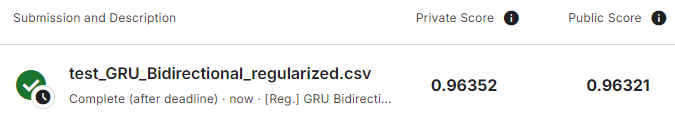

#### **Ensemble predictions submission**

> The ensemble model was submitted to Kaggle to evaluate whether combining predictions from the regularized bidirectional GRU and LSTM models improves performance by leveraging the strengths of both architectures.  

**Performance on Kaggle**  
  - Public Score: 0.96307  
  - Private Score: 0.96442  

> The ROC AUC scores are similar to the best individual models, suggesting that ensembling helps maintain strong ranking performance. However, the macro F1-score remains low, indicating that while the ensemble improves robustness, class imbalance issues persist.

In [ ]:
# Getting the final predictions
ensemble_test_preds_final = ensemble_prediction(gru_bi_regularized_model, lstm_bi_regularized_model, X_test_final)

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step
4787/4787 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step


In [ ]:
output_submission_file_from_preds(sample_submission, ensemble_test_preds_final, class_names, 'test_Ensemble.csv')

Submission file saved: test_Ensemble.csv


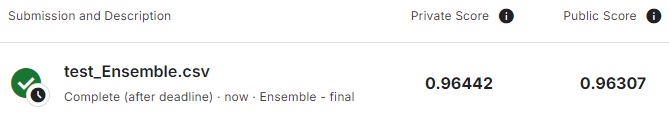

## **Some Classifications Examples**

> This section presents classification examples on entirely new, manually written comments. The ensemble model is used due to its balance between loss and performance.

> It is expected, seen by the F1-Score results, that the model will struggle on some classes, especially:
  - **Threat**
  - **Identity Hate**

> These classes are predicted less accurately due to class imbalance in the dataset. The distribution of labels shows that Threat and Identity Hate occur far less frequently than other categories, leading to fewer training examples for the model to learn from. As a result, the model struggles to correctly classify these cases, leading to lower F1-scores.

### **Useful Functions**


In [ ]:
# Function that prints, using the ensemble model, the predictions and classes of a given comment
def example_comment_prediction(sample_comment):
    # Preprocessing
    processed_tokens = preprocess_text(sample_comment)
    seq = text_to_sequence(processed_tokens, vocab)
    padded_seq = pad_sequences([seq], maxlen=200, padding='post')
    # Predictions
    predictions = ensemble_prediction(gru_bi_regularized_model, lstm_bi_regularized_model, padded_seq, verbose=0)[0]
    # Using the dataframe for printing
    df = pd.DataFrame({
        'Class': class_names,
        'Probability': predictions
    })
    # Classification of the comment
    max_prob_class = df.loc[df['Probability'].idxmax()]['Class']
    if df['Probability'].max() >= 0.5:
        print("---------------------")
        print("Comment Class: Toxic")
        print("---------------------")
    else:
        print("---------------------")
        print("Comment Class: Clean")
        print("---------------------")

    return df


### **Clean Comments Examples**

> As expected from the EDA, the model will be able to classify correctly the clean comments, as they are the most common.

In [ ]:
# Normal Comment
example_comment_prediction("This is a nice comment")

---------------------
Comment Class: Clean
---------------------


,Class,Probability
0,toxic,0.023041
1,severe_toxic,0.000156
2,obscene,0.003198
3,threat,0.000826
4,insult,0.006703
5,identity_hate,0.001240


In [ ]:
# Another Sample Comment
example_comment_prediction("Welcome to Wikipedia, I will help you find more knowledge :-)")

---------------------
Comment Class: Clean
---------------------


,Class,Probability
0,toxic,0.002267
1,severe_toxic,0.000022
2,obscene,0.000344
3,threat,0.000290
4,insult,0.000976
5,identity_hate,0.000314


### **Toxic Comments Examples**

> Based on the evaluation, some challenges are expected in classifying the **"threat"** and **"identity_hate"** classes.

In [ ]:
# Mostly toxic and obscene
example_comment_prediction("Wikipedia sucks")

---------------------
Comment Class: Toxic
---------------------


,Class,Probability
0,toxic,0.972258
1,severe_toxic,0.056530
2,obscene,0.846603
3,threat,0.018575
4,insult,0.658318
5,identity_hate,0.055397


In [ ]:
# Insult
example_comment_prediction("You are an idiot, fucker")

---------------------
Comment Class: Toxic
---------------------


,Class,Probability
0,toxic,0.996011
1,severe_toxic,0.416533
2,obscene,0.980459
3,threat,0.033969
4,insult,0.897906
5,identity_hate,0.114814


In [ ]:
# Severe Toxic
example_comment_prediction("Fuck you cunt asshole")

---------------------
Comment Class: Toxic
---------------------


,Class,Probability
0,toxic,0.997247
1,severe_toxic,0.589607
2,obscene,0.990434
3,threat,0.041354
4,insult,0.922051
5,identity_hate,0.135270


In [ ]:
# Identity hate
example_comment_prediction("Fuck off gay, blacks and jew people! LGBT and nigger monkeys!")

---------------------
Comment Class: Toxic
---------------------


,Class,Probability
0,toxic,0.994103
1,severe_toxic,0.464530
2,obscene,0.966132
3,threat,0.080292
4,insult,0.913326
5,identity_hate,0.223913


In [ ]:
# Threat - It struggles a bit (seen on F1 aswell)
example_comment_prediction("I will kill you, I found your house from your IP address! You are going to die!")

---------------------
Comment Class: Toxic
---------------------


,Class,Probability
0,toxic,0.808958
1,severe_toxic,0.016382
2,obscene,0.280066
3,threat,0.028481
4,insult,0.410670
5,identity_hate,0.060257


## **Results Analysis and Final Considerations**

### **Summary Table - Performance on Train and Validation**

| Model                    | Train Macro F1 | Train Loss | Val Macro F1 | Val Loss |
|-----------------------------|-------------------|------------|-----------------|----------|
| **NN Benchmark**         | 0.7133            | 0.0240   | 0.4907         | 0.0777  |
| **LSTM Baseline**         | 0.3901            | 0.1078     | 0.3810          | 0.0563   |
| **GRU Baseline**          | 0.5745            | 0.0379     | 0.5103          | 0.0525   |
| **Bi-LSTM Baseline**      | 0.4930            | 0.0398     | 0.4395          | 0.0521   |
| **Bi-GRU Baseline**       | 0.5502            | 0.0377     | 0.4909          | 0.0512   |
| **Bi-LSTM Regularized (Best Epoch)**   | 0.4556            | 0.0472     | 0.4375          | 0.0511   |
| **Bi-GRU Regularized (Best Epoch)**    | 0.4327            | 0.0477     | 0.4167          | 0.0496   |

From the train and validation performance:

- The NN Benchmark seems to have obtained the highest Macro F1 Score, while also overfitting a lot.

- The GRU Baseline also performed well, showing better validation scores compared to LSTM, which seems to be underfitting, since its loss is higher on train.

- The Bi-GRU Baseline demonstrated competitive results, with a solid balance between performance and loss but also showing more overfitting than the other RNNs. The Bi-LSTM presents overall lower scores than Bi-GRU

- The regularized models have some lower performances compared to the non-regularized models (especially GRU), but also the lowest loss on validation data, keeping the values very close the test data.

### **Summary Table - Performance on Test Data**

| Model                          | Test Macro F1 | Test Loss | ROC AUC | Kaggle Private Score | Kaggle Public Score |
|--------------------------------|---------|-----------|---------|--------------|--------------|
| **NN Benchmark**         | 0.4696         | 0.0963   | 0.9573       | 0.9570  | 0.9589 |
| **LSTM Baseline**              | 0.3446  | 0.0731    | 0.9595  | 0.9595      | 0.9588|
| **GRU Baseline**               | 0.4585  | 0.0887    | 0.9663  | 0.9660      | 0.9676 |
| **Bi-LSTM Baseline**           | 0.3817  | 0.0843    | 0.9637  | 0.9638       | 0.9630|
| **Bi-GRU Baseline**            | 0.4470  | 0.0811    | 0.9678  | 0.9671    | 0.9703|
| **Bi-LSTM Regularized** | 0.3667  | 0.0792    | 0.9615  | 0.9614      | 0.9606|
| **Bi-GRU Regularized**  | 0.3705  | 0.0749    | 0.9634  | 0.9635    | 0.9632|
| **Ensemble**                   | 0.3734  | 0.0754    | 0.9643  | 0.9644    | 0.9631|


On the test set:
- The NN Benchmark still achieves the best Macro F1 score, but when considering ROC AUC, models like GRU Baseline and Bi-GRU Baseline perform better with a much better loss, while still having some notable differences in train/test performances.

- Regularized versions of Bi-LSTM and Bi-GRU show improved generalization with the lowest test losses, while maintaining good scores in ROC AUC and Kaggle Scores. The test Macro F1 value is closer to the ones obtained in training, compared to the non-regularized models.

- The ensemble model, which averages predictions from the regularized models, provides a solid trade-off between loss and performance. While its Macro F1 score is not the highest, it achieves one of the best ROC AUC values (0.9643) and Kaggle scores, demonstrating its ability to maintain robust performance across different evaluation metrics. This suggests that ensembling helps reduce overfitting and stabilizes predictions.

### **Summary Table - Time per Epoch**

| Model                          | Average Time per Epoch |
|--------------------------------|------------------------|
| **NN Benchmark**               | ~15 seconds  |
| **LSTM Baseline**              | ~40 seconds  |  
| **GRU Baseline**               | ~40 seconds  |
| **Bi-LSTM Baseline**           | ~80 seconds  |  
| **Bi-GRU Baseline**            | ~75 seconds  |
| **Bi-LSTM Regularized**        | ~85 seconds  |
| **Bi-GRU Regularized**         | ~80 seconds  |

> Regarding training times, each model, except for the Benchmark NN, takes quite a while to train. With regularization in place, each epoch takes almost a minute and a half. For future work, the focus should certainly be on reducing training times. One possible direction is to explore different model types, such as CNNs. CNNs can be effective on sequences because they excel at extracting local patterns and can process data more efficiently through parameter sharing, making them faster than models like RNNs while still capturing important features.

### **Conclusions & Future Work**

> This study explored various deep learning architectures for multi-label text classification, comparing a fully connected baseline model with recurrent models like LSTM and GRU, including bidirectional and regularized variants. The results highlight key trade-offs in performance, generalization, and computational efficiency.  
  - The **NN Benchmark model** achieved the highest macro F1-score but suffered from significant overfitting.  
  - **GRU-based models** performed better than LSTM, achieving a higher ROC AUC while maintaining lower validation loss.  
  - **Bidirectional architectures** slightly improved ROC AUC but introduced more overfitting, particularly in non-regularized versions.  
  - **Regularization** helped mitigate overfitting, reducing validation loss while maintaining competitive ranking performance.  
  - The **ensemble model** provided a balanced trade-off, achieving strong ROC AUC and lower test loss while stabilizing predictions.

> To further improve performance, several aspects can be explored in **Future Work**:  
  - Techniques such as oversampling could improve F1-scores for underrepresented labels like **Threat** and **Identity Hate**.  
  - **CNNs** could be investigated as an alternative to RNNs, leveraging their efficiency in capturing local patterns while reducing training time.  
  - **Combining CNNs with RNNs** or Transformer-based models (such as BERT) may enhance feature extraction and sequence understanding.  
  - Using embeddings from models like FastText or **Word2Vec** could improve text representation, benefiting classification.  
  - Further tuning dropout rates, learning rates, and model depth could enhance generalization while maintaining efficiency, but with more computational power.
  - Model Pruning techniques to reduce the size of the already existing models.

> Overall, **GRU-based models with regularization provide the best balance between performance and generalization**, while ensembling helps stabilize predictions.

**Model Ranking based on Kaggle Private Score**

| Rank | Model                          | Private Score |
|------|--------------------------------|--------------|
| 1st  | GRU Bidirectional              | 0.96713      |
| 2nd  | GRU Baseline                   | 0.96602      |
| 3rd  | Ensemble Model                 | 0.96442      |
| 4th  | GRU Bidirectional Regularized  | 0.96352      |
| 5th  | LSTM Bidirectional             | 0.96376      |
| 6th  | LSTM Bidirectional Regularized | 0.96141      |
| 7th  | LSTM Baseline                  | 0.95952      |
| 8th  | NN Benchmark                   | 0.95695      |
